In [4]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier
import random

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
# import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
# from modAL.models impor ActiveLearner, Committee
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
import copy
from itertools import combinations, product
from sklearn.datasets import make_classification
# from alipy import ToolBox
# from alipy.utils.misc import nsmallestarg, randperm, nlargestarg

### Preprocess Data

In [5]:
# dataset_csv_path = './Dataset/CSECICIDS2018_improved'
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = os.listdir(dataset_csv_path)[:]
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']    
    improved_df = clean_df(improved_df)
    improved_df.drop(dropping_cols, axis = 1, inplace = True)
    improved_df['Label'].value_counts()    
    return improved_df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def preprocess_data(df, train_perc=0.15, random_state=42):
    # Make a copy of the dataframe
    improved_df = df.copy()
    
    # Clean the labels
    #* Remove Attack data labeled as Benign
    # attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    # improved_df.drop(['Attempted Category'], axis=1, inplace=True)
    # improved_df.replace(attepmted_labels, 'BENIGN', inplace=True)
    #* --

    # Sample the anomaly rate
    # print(f"improved_df.shape {improved_df.shape} Before Sampling Out")
    # improved_df = sample_df(improved_df, anomaly_rate)
    # print(f"improved_df.shape {improved_df.shape} after Sampling Out")
    # ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0] / improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    # print(f"Ratio of Benign to Anomaly is {ratio:.2f} : 1")
    
    # Prepare features and labels
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)  # Map BENIGN to 0 and others to 1
    X = improved_df.drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        Y, 
        test_size=1-train_perc, 
        shuffle=True, 
        stratify=Y, 
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

def balance_attack(df, atk_list, verbose=0):
    atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
    reduced_cicids_df = pd.DataFrame()
    for atk_name in atk_list:
        temp_df = df.loc[df["Label"] == atk_name]
        temp_df = temp_df.sample(n=min(temp_df.shape[0], 10_000))
        reduced_cicids_df = pd.concat([reduced_cicids_df, temp_df], ignore_index=True)
    
    benign_df = df.loc[df["Label"] == 'BENIGN']
    reduced_cicids_df = pd.concat([reduced_cicids_df, benign_df], ignore_index=True)
        
    if verbose:
        print(reduced_cicids_df["Label"].value_counts())
    return reduced_cicids_df
    
    
        
#* Usage
# read_csv() => balance_attack => define_atk / preprocess_data() =>Train()
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
cicids_df = read_csv()
reduced_cicids_df = balance_attack(cicids_df, atk_list, verbose=1)
cicids_df = reduced_cicids_df.copy()
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(reduced_cicids_df, train_perc=0.99, anomaly_rate)

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64


In [6]:
cicids_df['Label'].value_counts()
cicids_df['Attempted Category'].value_counts()
attepmted_labels = [s for s in cicids_df['Label'].unique() if 'Attempted' in s]

cicids_df.drop(['Attempted Category'], axis = 1, inplace = True)

cicids_df.replace(attepmted_labels, 'BENIGN', inplace = True)
cicids_df['Label'].value_counts()

Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64

Attempted Category
0    1642660
Name: count, dtype: int64

Label
BENIGN                     1582561
Portscan                     10000
DoS Hulk                     10000
DDoS                         10000
Infiltration - Portscan      10000
DoS GoldenEye                 7567
FTP-Patator                   3972
DoS Slowloris                 3859
SSH-Patator                   2961
DoS Slowhttptest              1740
Name: count, dtype: int64

In [7]:
# cicids_scaler = StandardScaler()
# y = cicids_df["Label"]  # Extract labels
# X = cicids_df.drop(columns=["Label"])  # Extract features
# X_scaled = pd.DataFrame(cicids_scaler.fit_transform(X), columns=X.columns)  # Scale features

# # Combine scaled features and labels
# cicids_df_scaled = X_scaled.copy()
# cicids_df_scaled["Label"] = y

# # Check the resulting DataFrame
# cicids_df_scaled.head()

# cicids_df = cicids_df_scaled.copy()
# cicids_df


In [8]:
# Shuffle the Benign Data
benign_df = cicids_df.loc[cicids_df["Label"] == "BENIGN"]
benign_df = benign_df.sample(frac=1).reset_index(drop=True)
benign_df

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,175,2,2,80,112,40,40,40.000000,0.000000,56,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1,4865807,6,3,123,46,46,0,20.500000,23.114930,46,...,0,0,0.000000e+00,0.000000,0,0,0,0,181237094,BENIGN
2,117496233,19,16,1158,500,579,0,60.947368,182.559723,250,...,2228512,36301,1.018312e+07,57802.194154,10203701,10011255,0,0,117496233,BENIGN
3,53519692,23,38,1455,50897,597,0,63.260870,154.928200,2896,...,1213909,1213909,5.217384e+07,0.000000,52173837,52173837,0,0,53519692,BENIGN
4,170,2,2,76,172,38,38,38.000000,0.000000,86,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582556,127023,8,7,358,3776,201,0,44.750000,76.734701,1460,...,0,0,0.000000e+00,0.000000,0,0,0,0,127023,BENIGN
1582557,2250268,2,2,92,250,51,41,46.000000,7.071068,183,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1582558,188,2,2,64,158,32,32,32.000000,0.000000,79,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1582559,31018,2,2,60,92,30,30,30.000000,0.000000,46,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN


### Defining Global and Local Model

In [9]:
def set_supervised_label(supervision_rate, y, idx):
        if supervision_rate == 0:
            y[idx[:2]] = 1
        else:
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
      
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold  
      
class Global_Model():
  def __init__(self, initial_data):
      self.initial_data = initial_data.copy() #Initially Empty
      self.gm_data = None
      self.gm_retrain(supervision=1.0)


  def gm_retrain(self, new_gm_data=None, supervision=0):
      if new_gm_data is None:
          training_data = self.initial_data
      else:
          # Combine new data with existing GM data
          self.gm_data = pd.concat([self.gm_data, new_gm_data], ignore_index=True)
          training_data = pd.concat([self.initial_data, self.gm_data], ignore_index=False)
          
          
      
      print("GM Training Data Size", training_data.shape)
      label = training_data["Label"]
      training_data = training_data.drop(columns=["Label"])
      # Train-test split
      X_train, X_test, y_train, y_test = train_test_split(
          training_data, label, shuffle=True, test_size=0.2, random_state=4022
      )
      # Prepare labels for semi-supervised learning
      idx = np.where(y_train == 1)[0]
      y_train = np.zeros_like(y_train)  # Initialize with zeros
      y_train = set_supervised_label(supervision, y_train, idx)

      # Train the model
      model = PReNet
      self.clf = model(device="cuda", verbose=1, epochs=1, batch_size=64)
      self.clf.fit(X_train.to_numpy(), y=y_train)
      
      # Calculate optimal threshold
      anomaly_scores = self.clf.decision_function(X_test.to_numpy())
      precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
      opt_threshold = get_optimal_threshold(precision, recall, thresholds)
      self.opt_threshold = opt_threshold      

      # Perform inference to evaluate the model
      output, anomaly_scores = self.perform_inference(X_test, y_test)
    # return clf, model
              
  def perform_inference(self, X, y_real=None):  
      anomaly_scores = self.clf.decision_function(X.to_numpy())
      output = np.where(anomaly_scores > self.opt_threshold, 1,0)
      
      if y_real is not None:
          print("Accuracy of GM: ", accuracy_score(output, y_real))
      return output, anomaly_scores

In [10]:
class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic', verbosity=0)
        # self.model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
        #                                     min_samples_leaf=10, 
        #                                     # ccp_alpha=0.01, #Pruning coef
        #                                     random_state=4022)
        self.global_model = gm 
        self.lm_data = pd.DataFrame()
        self.knowledge_pool = []
                
    def retrain_model(self, new_lm_data, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        # known_df = self.load_known_df()
        # filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        
        # if update_gm:
        #     filtered_new_data["Label"] = 0
        #     self.global_model.update_data(filtered_new_data)
        # # TODO: After updating return the labels or recall the function
        # else:
        
        y_real = new_lm_data["Label"].copy()
        X_new = new_lm_data.drop(columns=["Label"]).copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y_real, shuffle=True, test_size=0.2, random_state=4022
        )

        # Use the global model to inquire labels for X_train
        y_new = self.inquire_gm(X_train, y_train)

        # Combine X_train and the inferred labels into a DataFrame
        new_training_data = X_train.copy()
        new_training_data["Label"] = y_new

        # Append new training data to the local model's data
        self.lm_data = pd.concat([self.lm_data, new_training_data], ignore_index=True)

        # Retrain the local model using the updated data
        self.model.fit(self.lm_data.drop(columns=["Label"]), self.lm_data["Label"])

        # Evaluate the updated model (optional, based on your implementation)
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        self.share_knowledge(X_train, y_new)

        return acc
    
    def share_knowledge(self, X_new, y_new):
        X_new["Label"] = y_new
        for neigh_area in self.knowledge_pool:
            neigh_lm = neigh_area.local_model
            neigh_lm.lm_data = pd.concat([neigh_lm.lm_data, X_new.copy()], ignore_index=True)
            neigh_lm.model.fit(neigh_lm.lm_data.drop(columns=["Label"]), neigh_lm.lm_data["Label"])
        
        
    def inquire_gm(self, X_query, y_real=None): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label, _ = self.global_model.perform_inference(X_query, y_real)
        X_query_df = pd.DataFrame(X_query)
        # X_query_df["Label"] = pseudo_label
        return pseudo_label
    
    def perform_inference(self, X):
        output = self.model.predict(X) 
        return output    
    
    def select_data(self, known_df, X_new, threshold, y_new):
        round = 10
        informative_score_list = []
        y_new = np.ones(X_new.shape[0]) * 2 if y_new is None else y_new
        model = self.model
        
        X_known = known_df.drop(columns=["Label"], inplace = False).copy()
        y_known = known_df["Label"]
        # X_known.drop(columns=["Src IP", "Dst IP"], inplace=True)
        X = pd.concat([X_known, X_new], ignore_index=True)
        y = np.concatenate([y_known, y_new]).astype(int)
        print(y)
        label_ind = np.arange(len(X_known))
        print("Size of Label Index", len(X_known))
        unlab_ind = np.arange(len(X_known), len(X))

        divided_arrays = np.array_split(unlab_ind, round)
        
        alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,) 
        alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=10)     
        strategy_name = "QueryInstanceUncertainty"
        strategy = alibox_new.get_query_strategy(strategy_name=strategy_name) #TODO Replace Alibox with a single function
        for i in range(round):
            batch_size = 1000 
            print(f"Round {i}")
            # Use AL to Select Data

            
            select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=divided_arrays[i], 
                                                            threshold=threshold, custom = True, model=model, batch_size=batch_size)
            print(select_ind)
            # select_ind = select_ind[np.where(np.array(informative_score) > threshold)[0]]
                              
            batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
            print(batch_size)
            # Upload Data to GM
            idx_to_query = select_ind[:batch_size]
            if len(idx_to_query) > 0:
                if 2.0 in y_new: 
                    pseudo_labels = self.inquire_gm(X.iloc[idx_to_query]) 
                    y[idx_to_query] = pseudo_labels 
                else: # ? Set GM to be 100% Accurate
                    pseudo_labels = y[idx_to_query]
                    # y[idx_to_query] = pseudo_labels
                print(f"New Label Counts: {Counter(y[select_ind[:batch_size]])}")    
                label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
                mask = np.where(np.isin(unlab_ind, select_ind[:batch_size], invert=True)) # unlab_ind.difference_update(select_ind)
                unlab_ind = unlab_ind[mask]
                
                print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
                #Update The Model
                X_scaled = self.scaler.transform(X.iloc[label_ind]) 
                print("Number of duplicates", len(label_ind) - len(np.unique(label_ind)))
                model = self.model
                print(label_ind)
                print(f"np.unique: {np.unique(y[label_ind])}")
                model.fit(X=X_scaled, y=y[label_ind]) 
                # pred = model.predict(X_test)
                # query_accuracy = metric(pred, y_test)      
            else:
                print("No Data Added")
            print(informative_score[:100])
            informative_score_list.append(informative_score)

            
        merged_train_df = pd.DataFrame(X.iloc[label_ind], columns = features[2:])
        merged_train_df["Label"] = y[label_ind]
        new_train_df = merged_train_df.iloc[len(X_known):]
        return new_train_df, informative_score_list, model
        



### Defining Area

In [35]:
class Attack:
    def __init__(self, name, centroid, std_dev, data):
        self.name = name
        self.centroid = centroid
        self.std_dev = std_dev
        self.data, self.test_data = train_test_split(data, train_size=0.8, random_state=42)
        self.active = False
        self.rr_counter = 0  # Round Robin Counter
        self.first_seen = random.uniform(0,30)

    def get_data(self):
        chunk_size = self.data.shape[0] // 20  # Divide into 10 chunks
        start_idx = self.rr_counter * chunk_size
        end_idx = start_idx + chunk_size
        if self.rr_counter == 9:
            end_idx = self.data.shape[0]  # Include all remaining rows
        self.rr_counter = (self.rr_counter + 1) % 20
        return self.data.iloc[start_idx:end_idx]
        

def define_edge_area(num_edge_area, gm=None, random_state=42, global_sharing=False):
    random.seed(random_state)
    area_list = [Edge_Area((random.uniform(0, 1), random.uniform(0, 1)), gm) for _ in range(num_edge_area)]
    local_model = Local_Model(gm) 
    for edge_area in area_list:
        centroid = edge_area.centroid
        distances = [
            np.sqrt((other_area.centroid[0] - centroid[0])**2 + (other_area.centroid[1] - centroid[1])**2)
            for other_area in area_list
        ]
        # Get the indices of the two smallest distances, excluding itself
        closest_indices = np.argsort(distances)[1:3]  # Skip the first (distance to itself)
        if gm is not None:
            edge_area.local_model.knowledge_pool = [area_list[i] for i in closest_indices] #?Cluster KS
            # edge_area.local_model.knowledge_pool = [] #? No KS
        #* Global Knowledge Sharing
        if global_sharing:
            # local_model = Local_Model(gm) 
            # edge_area.local_model.knowledge_pool = []
            edge_area.local_model = local_model
    return area_list

def define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=42):
    random.seed(random_state)
    atk_info_dict = {}
    anomaly_ratio = 25
    benign_idx = 0
    for idx, atk in enumerate(atk_list):
        # Cycle through edge areas
        edge_area = edge_area_list[idx % len(edge_area_list)]

        # Define standard deviations
        std_dev = (random.uniform(0.2, 0.4), random.uniform(0.2, 0.4))

        # Offset the attack centroid relative to the edge area centroid
        atk_centroid = (
            edge_area.centroid[0] + random.uniform(-std_dev[0], std_dev[0]) / 3,
            edge_area.centroid[1] + random.uniform(-std_dev[1], std_dev[1]) / 3
        )

        # Filter attack-specific data
        atk_data = cicids_df.loc[cicids_df["Label"] == atk]

        # Get corresponding benign data based on anomaly ratio
        benign_count = atk_data.shape[0] * anomaly_ratio
        benign_data = benign_df.iloc[benign_idx: benign_idx + benign_count]
        benign_idx += benign_count

        # Ensure benign_idx doesn't exceed benign_df bounds
        if benign_idx > len(benign_df):
            benign_idx = len(benign_df)  # Prevent index out of bounds
            print("Index Out of Bounds", atk)

        # Concatenate benign and attack data
        data = pd.concat([benign_data, atk_data], ignore_index=True)
        data = data.sample(frac=1).reset_index(drop=True)
        # data["Label"] = data["Label"].map({"BENIGN": 0}).fillna(1)

        # Create and store an Attack object
        atk_info_dict[atk] = Attack(atk, atk_centroid, std_dev, data)

    return atk_info_dict


class Edge_Area:
    def __init__(self, centroid, gm=None):
        self.centroid = centroid
        self.seen_attack_acc = dict() # Values as List of (t, acc)
        if gm != None:
            self.local_model = Local_Model(gm)
    def create_knowledge_sharing_pool(self):
        # TODO: Get the closest based on euclidean distance
        self.sharing_pool = None
    def train_local_model(self, new_lm_data):
        return self.local_model.retrain_model(new_lm_data)



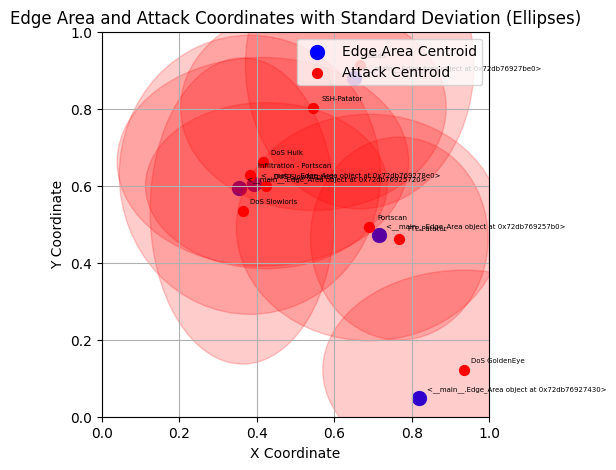

In [12]:
from matplotlib.patches import Ellipse

# Function to visualize edge areas and attack coordinates with standard deviation as ellipses
def visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_list):
    plt.figure(figsize=(5, 5))
    
    # Plot edge area centroids
    for edge_area in edge_area_list:
        plt.scatter(edge_area.centroid[0], edge_area.centroid[1], c='blue', label='Edge Area Centroid', s=100)
        plt.text(edge_area.centroid[0] + 0.02, edge_area.centroid[1] + 0.02, edge_area, fontsize=5)
    
    # Plot attack centroids with standard deviation
    for attack in atk_info_list:
        plt.scatter(attack.centroid[0], attack.centroid[1], c='red', label='Attack Centroid', s=50)
        plt.text(attack.centroid[0] + 0.02, attack.centroid[1] + 0.02, attack.name, fontsize=5)
        
        # Plot standard deviation as an ellipse around the centroid
        std_x, std_y = attack.std_dev
        ellipse = Ellipse(
            xy=attack.centroid,
            width=2 * std_x,  # Full width of the ellipse
            height=2 * std_y,  # Full height of the ellipse
            edgecolor='red',
            facecolor='red',
            alpha=0.2
        )
        plt.gca().add_patch(ellipse)
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.title("Edge Area and Attack Coordinates with Standard Deviation (Ellipses)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    

num_edge_areas = 5
seed = 4028
edge_area_list = define_edge_area(num_edge_areas, random_state=seed)

atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=seed)
visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_dict.values())


# Bivariate Normal Distribution

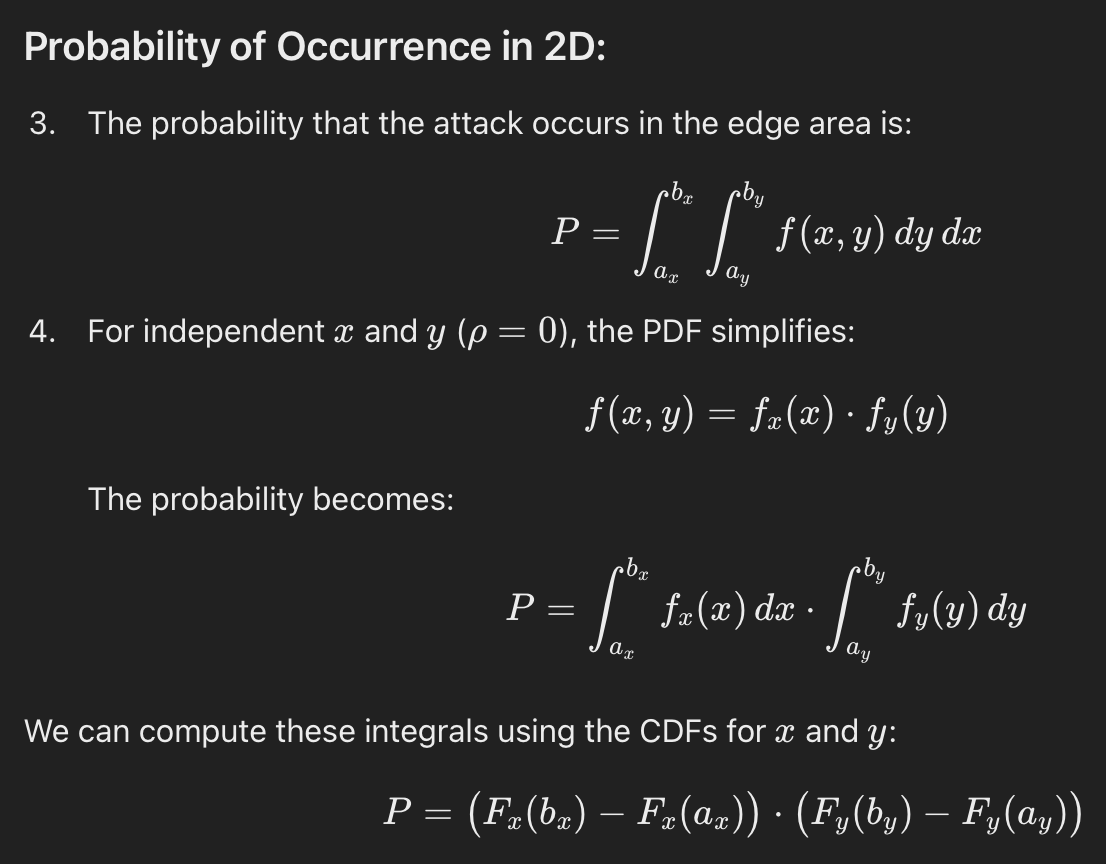

In [13]:
from scipy.stats import norm

def probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y):
    (a_x, b_x) = (area_centroid_x-0.1, area_centroid_x+0.1)
    (a_y, b_y) = (area_centroid_y-0.1, area_centroid_y+0.1)

    # Probability in x-dimension
    p_x = norm.cdf(b_x, loc=mu_x, scale=sigma_x) - norm.cdf(a_x, loc=mu_x, scale=sigma_x)
    # Probability in y-dimension
    p_y = norm.cdf(b_y, loc=mu_y, scale=sigma_y) - norm.cdf(a_y, loc=mu_y, scale=sigma_y)

    # Total probability in the 2D region
    return p_x * p_y

# Example usage
mu_x, sigma_x = 0.5, 0.1  # Mean and std deviation for x
mu_y, sigma_y = 0.5, 0.1  # Mean and std deviation for y
area_centroid_x, area_centroid_y = (0.4, 0.4)  # Edge area bounds for x and y

probability = probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y)
print(f"Probability of attack occurring in the edge area: {probability:.4f}")


Probability of attack occurring in the edge area: 0.2278


### Initial Training of Local and Global Model

Global Model = 3 Atk, 
Local Model = None

In [14]:
# #### Sample out Malicious data such that it would become an outlier
# print(f'improved_df.shape {cicids_df.shape} Before Sampling Out')
# cicids_df = pd.concat([cicids_df[cicids_df['Label'] == 'BENIGN'], cicids_df[cicids_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
# print(f'improved_df.shape {cicids_df.shape} after Sampling Out')
ratio = cicids_df.loc[cicids_df["Label"] == "BENIGN"].shape[0]/ cicids_df.loc[cicids_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

Ratio of Benign to Anomaly is 26.332567929582854 : 1


In [15]:
num_edge_areas = 5
edge_area_list = define_edge_area(num_edge_areas)

# atk_list = ["Portscan", "DoS Hulk", "DDoS", "DoS DoS Hulk", "Infiltration - Portscan"]
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df, benign_df)
#TODO: Randomly choose 3 attacks from the list, set the first_seen_t = 0, train the global model using this 3 attacks

first_seen_atk = ["DoS Hulk", "DDoS"]
gm_training_data = pd.DataFrame()
# Set Training Data for GM
for atk in first_seen_atk:
    # curr_atk_df = cicids_df.loc[cicids_df["Label"] == atk].copy()
    curr_atk_df = atk_info_dict[atk].data.copy()
    curr_atk_df = curr_atk_df.sample(frac=0.3).reset_index(drop=True)
    gm_training_data = pd.concat([gm_training_data, curr_atk_df], ignore_index=True) #Train with 0.2 of the attack data

    # gm_training_data["Label"] = gm_training_data["Label"].map({"BENIGN":0}).fillna(1)
    # gm_training_data = gm_training_data.sample(frac=1).reset_index(drop=True)
    
y = gm_training_data["Label"].copy()

# gm_training_data = pd.DataFrame(scaler.fit_transform(gm_training_data), columns = curr_atk_df.columns)
gm_training_data["Label"] = y
# gm = Global_Model(gm_training_data)

In [16]:
gm_training_data["Label"].unique()

array(['BENIGN', 'DoS Hulk', 'DDoS'], dtype=object)

In [17]:
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
#     gm_training_data.drop(columns=["Label"]), gm_training_data["Label"], shuffle=True, test_size=0.2, random_state=4022
# )
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
#     cicids_df_scaled.drop(columns=["Label"]), cicids_df_scaled["Label"].map({"BENIGN": 0}).fillna(1), shuffle=True, test_size=0.2, random_state=4022
# )
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(cicids_df)
X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(gm_training_data, train_perc=0.99)

In [18]:
lm_clf = DecisionTreeClassifier(criterion='entropy', 
                                # max_depth=5,  
                                # min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf.fit(X_gm_train, y_gm_train)
# Predict on the training data
y_pred = lm_clf.predict(X_gm_test)

# Calculate metrics
acc = accuracy_score(y_gm_test, y_pred)
f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
print(acc, f1)

DecisionTreeClassifier(criterion='entropy', random_state=4022)

1.0 1.0


In [19]:
y_gm_test.value_counts()

Label
0.0    1201
1.0      48
Name: count, dtype: int64

### Start Simulation

Initial GM Training

In [45]:
X_gm_train["Label"] = y_gm_train.values
print(X_gm_train["Label"].value_counts())
global_model = Global_Model(X_gm_train[:200].copy())
# global_model = Global_Model(X_gm_train[:].copy())

Label
0.0    118759
1.0      4792
Name: count, dtype: int64
GM Training Data Size (200, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 3.038432, time: 0.0s
Start Inference on the training data...
Accuracy of GM:  0.0


In [46]:
# TODO: Compare Different Epochs
# atk_list = ["Portscan", "DoS Hulk", "DDoS"]

LIGHT_GREEN = '\033[92m'  # Light green
GREEN = '\033[32m'  # Green
BLUE = '\033[34m'  # Green
PURPLE = '\033[35m'  # Green

RESET = '\033[0m'   # Reset to default color


# Example usage
num_runs = 1
num_timesteps = 300
num_edge_area = 5
supervision = 0.05


In [47]:
# To change global or clustering sharing tweak define_edge_area(global_sharing=True/False)
# To change to no knowledge sharing change edge_area.local_model.knowledge_pool to []

In [48]:
from sklearn.exceptions import NotFittedError
import gc

# Main simulation function
final_accuracies = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    run=run+1

    # Initialize Global Model
    # global_model = Global_Model(gm_training_data[:100000])
    
    # Assign edge area coordinates
    edge_area_list = define_edge_area(5, global_model, random_state=run, global_sharing=True)

    # Define attack information
    atk_info_list = define_atk(atk_list, edge_area_list, cicids_df, benign_df, random_state=run)

    # Loop through timesteps
    for t in range(num_timesteps):
        for attack in atk_info_list.values():
            # Sample whether an attack is ongoing
            for i, edge_area in enumerate(edge_area_list):
                occ_prob = probability_in_2d_edge_area(attack.centroid[0], attack.std_dev[0], 
                                                        attack.centroid[1], attack.std_dev[1], 
                                                        edge_area.centroid[0], edge_area.centroid[1])
                attack.active = np.random.random() < occ_prob/3
                if attack.active and attack.first_seen < t:
                    # Train local model with a fraction of the data     
                    X_lm_train, X_lm_test, y_lm_train, y_lm_test = preprocess_data(attack.get_data().copy(), train_perc=0.8)                   
                    print(y_lm_train.value_counts(), y_lm_test.value_counts())
                    y_lm_train = y_lm_train.values
                    y_lm_test = y_lm_test.values
                    # Record Accuracy Data
                    X_atk_test, _, y_atk_test, _ = preprocess_data(attack.get_data().copy(), train_perc=0.99)                   
                    y_atk_test = y_atk_test.values
                    
                    # Evaluate GM Accuracy
                    y_gm_pred = edge_area.local_model.inquire_gm(X_lm_test)
                    gm_acc = accuracy_score(y_gm_pred, y_lm_test)
                    gm_f1 = f1_score(y_gm_pred, y_lm_test, average='binary')
                    
                    y_gm_atk_pred = edge_area.local_model.inquire_gm(X_atk_test)
                    gm_atk_acc = accuracy_score(y_gm_atk_pred, y_atk_test)
                    gm_atk_f1 = f1_score(y_gm_atk_pred, y_atk_test, average='binary')                    

                    # Evaluate LM Accuracy
                    try:
                        # Perform inference using the local model
                        y_lm_pred = edge_area.local_model.perform_inference(X_lm_test)
                        lm_acc = accuracy_score(y_lm_pred, y_lm_test)
                        lm_f1 = f1_score(y_lm_pred, y_lm_test, average='binary')
                        
                        y_lm_atk_pred = edge_area.local_model.perform_inference(X_atk_test)
                        lm_atk_acc = accuracy_score(y_lm_atk_pred, y_atk_test)
                        lm_atk_f1 = f1_score(y_lm_atk_pred, y_atk_test, average='binary')
                        

                    except NotFittedError as e:
                        # Handle the case where the model is not yet fitted
                        print("Local model is not fitted yet. Please fit the model before inference.")
                        lm_acc = 0
                        lm_f1 = 0
                        
                        lm_atk_acc = 0
                        lm_atk_f1 = 0
                    print(f"Timestep {t}, Area {i} Attack {attack.name}")
                    print(f"{LIGHT_GREEN}Accuracy of GM Before: {gm_acc} {gm_f1} || {gm_atk_acc} {gm_atk_f1} {RESET} ")                            
                    print(f"{LIGHT_GREEN}Accuracy of LM Before: {lm_acc:.2f} {lm_f1} || {lm_atk_acc} {lm_atk_f1} {RESET}")                            
                    
                    # Update seen_attack_acc
                    if attack.name not in edge_area.seen_attack_acc:
                        edge_area.seen_attack_acc[attack.name] = [(t, lm_atk_acc, lm_atk_f1)]
                    else:
                        edge_area.seen_attack_acc[attack.name].append((t, lm_atk_acc, lm_atk_f1))
                        
                    if gm_f1 < 0.96: #* GM is the bottleneck
                        X_lm_train["Label"] = y_lm_train
                        print("GM New Data Size", X_lm_train.shape[0])
                        edge_area.local_model.global_model.gm_retrain(X_lm_train, supervision=supervision)
                        y_gm_pred = edge_area.local_model.inquire_gm(X_lm_test)
                        gm_acc = accuracy_score(y_gm_pred, y_lm_test)
                        gm_f1 = f1_score(y_gm_pred, y_lm_test, average='binary')
                        
                        y_gm_atk_pred = edge_area.local_model.inquire_gm(X_atk_test)
                        gm_atk_acc = accuracy_score(y_gm_atk_pred, y_atk_test)
                        gm_atk_f1 = f1_score(y_gm_atk_pred, y_atk_test, average='binary')  
                            
                        print(f"{BLUE}Accuracy of GM After: {gm_acc} {gm_f1} || {gm_atk_acc} {gm_atk_f1} {RESET} ")
                    if lm_f1 < 0.96: #* LM Haven't Learn about the data
                        X_lm_train["Label"] = y_lm_train
                        lm_acc = edge_area.train_local_model(X_lm_train)
                        y_lm_pred = edge_area.local_model.perform_inference(X_lm_test)
                        lm_f1 = f1_score(y_lm_pred, y_lm_test, average='binary')
                        
                        y_lm_atk_pred = edge_area.local_model.perform_inference(X_atk_test)
                        lm_atk_acc = accuracy_score(y_lm_atk_pred, y_atk_test)
                        lm_atk_f1 = f1_score(y_lm_atk_pred, y_atk_test, average='binary')
                                                
                        print(f"{PURPLE}Accuracy of LM After: {lm_acc} {lm_f1} || {lm_atk_acc} {lm_atk_f1} {RESET} ")
                    print(attack.name, X_lm_train.shape)
                    gc.collect()
                    



Run 1/1
Label
0.0    7974
1.0     346
Name: count, dtype: int64 Label
0.0    1993
1.0      87
Name: count, dtype: int64
Local model is not fitted yet. Please fit the model before inference.
Timestep 3, Area 0 Attack Infiltration - Portscan
Accuracy of GM Before: 0.046153846153846156 0.07977736549165121 || 0.04176784847013113 0.06890042472864559  
Accuracy of LM Before: 0.00 0 || 0 0 
GM New Data Size 8320
GM Training Data Size (8520, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.924124, time: 0.3s
Start Inference on the training data...
Accuracy of GM:  0.9970657276995305
Accuracy of GM After: 0.9980769230769231 0.9770114942528736 || 0.9967945604662457 0.9541029207232267  
Accuracy of GM:  0.9983473557692307
Accuracy of LM After: 0.9981971153846154 0.9770114942528736 || 0.9645458960660515 0.0  
Infiltration - Portscan (8320, 82)


20415

Label
0.0    7988
1.0     332
Name: count, dtype: int64 Label
0.0    1997
1.0      83
Name: count, dtype: int64
Timestep 4, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9966346153846154 0.9585798816568047 || 0.9956289460903351 0.9473684210526315  
Accuracy of LM Before: 0.96 0.0 || 0.9577464788732394 0.0 
GM New Data Size 8320
GM Training Data Size (16840, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.732113, time: 0.9s
Start Inference on the training data...
Accuracy of GM:  0.9973277909738717
Accuracy of GM After: 0.9961538461538462 0.9493670886075949 || 0.9963088878096164 0.9547619047619048  
Accuracy of GM:  0.9984975961538461
Accuracy of LM After: 0.9987980769230769 0.9559748427672956 || 0.9956289460903351 0.9479768786127167  
Infiltration - Portscan (8320, 82)


11939

Label
0.0    6066
1.0     229
Name: count, dtype: int64 Label
0.0    1517
1.0      57
Name: count, dtype: int64
Timestep 14, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9650571791613723 0.09836065573770492 || 0.9602053915275995 0.06060606060606061  
Accuracy of LM Before: 0.96 0.0 || 0.9605905006418485 0.0 
GM New Data Size 6295
GM Training Data Size (23135, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.675508, time: 1.6s
Start Inference on the training data...
Accuracy of GM:  0.9933001945104819
Accuracy of GM After: 0.9777636594663278 0.6067415730337079 || 0.9825417201540436 0.746268656716418  
Accuracy of GM:  0.9859015091342335
Accuracy of LM After: 0.9896743447180302 0.6136363636363636 || 0.9640564826700898 0.13043478260869565  
DoS GoldenEye (6295, 82)


9441

Label
0.0    8022
1.0     298
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 18, Area 2 Attack DDoS
Accuracy of GM Before: 0.9615384615384616 0.047619047619047616 || 0.9568722680913064 0.075  
Accuracy of LM Before: 0.96 0.0 || 0.9567751335599806 0.0 
GM New Data Size 8320
GM Training Data Size (31455, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.554317, time: 2.7s
Start Inference on the training data...
Accuracy of GM:  0.9925290096963917
Accuracy of GM After: 0.9966346153846154 0.9548387096774194 || 0.9959203496843128 0.9521640091116174  
Accuracy of GM:  0.9954927884615384
Accuracy of LM After: 0.9963942307692307 0.9548387096774194 || 0.995726080621661 0.9491916859122402  
DDoS (8320, 82)


10607

Label
0.0    8002
1.0     318
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 19, Area 3 Attack DoS Hulk
Accuracy of GM Before: 0.9889423076923077 0.8456375838926175 || 0.9889266634288489 0.848404255319149  
Accuracy of LM Before: 0.96 0.023529411764705882 || 0.9628946090335114 0.16593886462882096 
GM New Data Size 8320
GM Training Data Size (39775, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.502870, time: 3.8s
Start Inference on the training data...
Accuracy of GM:  0.9959773727215587
Accuracy of GM After: 0.9980769230769231 0.9743589743589743 || 0.9941719281204469 0.9212598425196851  
Accuracy of GM:  0.9977463942307693
Accuracy of LM After: 0.9981971153846154 0.9808917197452229 || 0.996600291403594 0.9515905947441217  
DoS Hulk (8320, 82)


11939

Label
0.0    7978
1.0     342
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 27, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9966346153846154 0.9580838323353293 || 0.9974745021855269 0.9658792650918635  
Accuracy of LM Before: 1.00 0.9824561403508771 || 0.9981544439048081 0.9752925877763329 
GM New Data Size 8320
GM Training Data Size (48095, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.445579, time: 6.0s
Start Inference on the training data...
Accuracy of GM:  0.9938663062688429
Accuracy of GM After: 0.9923076923076923 0.9080459770114943 || 0.9945604662457503 0.9291139240506329  
Infiltration - Portscan (8320, 82)


10550

Label
0.0    8003
1.0     317
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 28, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9961538461538462 0.9506172839506173 || 0.9951432734337057 0.9360613810741688  
Accuracy of LM Before: 1.00 0.9605263157894737 || 0.999125789218067 0.9882044560943644 
GM New Data Size 8320
GM Training Data Size (56415, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.404821, time: 8.0s
Start Inference on the training data...
Accuracy of GM:  0.994327749711956
Accuracy of GM After: 0.9985576923076923 0.9806451612903225 || 0.9975716367168529 0.9666221628838452  
Infiltration - Portscan (8320, 82)


10550

Label
0.0    1381
1.0      66
Name: count, dtype: int64 Label
0.0    346
1.0     16
Name: count, dtype: int64
Timestep 29, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9558011049723757 0.0 || 0.9670391061452513 0.0  
Accuracy of LM Before: 0.95 0.0 || 0.964245810055866 0.0 
GM New Data Size 1447
GM Training Data Size (57862, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.420218, time: 8.5s
Start Inference on the training data...
Accuracy of GM:  0.9957660070854575
Accuracy of GM After: 0.9917127071823204 0.896551724137931 || 0.9893854748603352 0.7764705882352941  
Accuracy of GM:  0.9887640449438202
Accuracy of LM After: 0.996551724137931 0.896551724137931 || 0.9815642458100559 0.6451612903225806  
DoS Slowhttptest (1447, 82)


3425

Label
0.0    8026
1.0     294
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 34, Area 0 Attack Portscan
Accuracy of GM Before: 0.9913461538461539 0.8615384615384616 || 0.9947547353084021 0.9283819628647215  
Accuracy of LM Before: 1.00 0.9793103448275862 || 0.9891209324915007 0.8390804597701149 
GM New Data Size 8320
GM Training Data Size (66182, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.419765, time: 10.6s
Start Inference on the training data...
Accuracy of GM:  0.9961471632545139
Accuracy of GM After: 0.9971153846153846 0.9577464788732394 || 0.9996114618746964 0.9950248756218906  
Portscan (8320, 82)


10550

Label
0.0    6015
1.0     280
Name: count, dtype: int64 Label
0.0    1504
1.0      70
Name: count, dtype: int64
Timestep 40, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9904701397712834 0.8818897637795275 || 0.986007702182285 0.7761806981519507  
Accuracy of LM Before: 0.97 0.5416666666666666 || 0.9757381258023107 0.4793388429752066 
GM New Data Size 6295
GM Training Data Size (72477, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.408216, time: 12.0s
Start Inference on the training data...
Accuracy of GM:  0.9942742825607064
Accuracy of GM After: 0.9828462515883101 0.7652173913043478 || 0.9843388960205391 0.7489711934156379  
Accuracy of GM:  0.9847100873709294
Accuracy of LM After: 0.982525814138205 0.7758620689655172 || 0.9772785622593068 0.5795724465558195  
DoS GoldenEye (6295, 82)


9441

Label
0.0    8008
1.0     312
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 42, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9956730769230769 0.9395973154362416 || 0.9971038806233721 0.9607655502392345  
Accuracy of LM Before: 1.00 0.9736842105263158 || 0.9984636439892278 0.9794956398774453 
GM New Data Size 8320
GM Training Data Size (80797, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.391975, time: 14.6s
Start Inference on the training data...
Accuracy of GM:  0.9965965346534653
Accuracy of GM After: 0.9985576923076923 0.9803921568627451 || 0.998746192221094 0.983380149812734  
Infiltration - Portscan (8320, 82)


0

Label
0.0    7992
1.0     328
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 43, Area 2 Attack Portscan
Accuracy of GM Before: 0.99375 0.9139072847682119 || 0.9981544439048081 0.9777777777777777  
Accuracy of LM Before: 1.00 1.0 || 0.9992229237493929 0.9906976744186047 
GM New Data Size 8320
GM Training Data Size (89117, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.389137, time: 18.2s
Start Inference on the training data...
Accuracy of GM:  0.9956238779174147
Accuracy of GM After: 1.0 1.0 || 0.999125789218067 0.9896432681242808  
Portscan (8320, 82)


10550

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 44, Area 3 Attack DDoS
Accuracy of GM Before: 0.9961538461538462 0.9473684210526315 || 0.9964060223409422 0.9564193168433451  
Accuracy of LM Before: 0.99 0.8444444444444444 || 0.9620203982515785 0.14065934065934066 
GM New Data Size 8320
GM Training Data Size (97437, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.395517, time: 22.4s
Start Inference on the training data...
Accuracy of GM:  0.9955357142857143
Accuracy of GM After: 0.9990384615384615 0.9873417721518988 || 0.9966974259349198 0.9597156398104265  
Accuracy of GM:  0.9965444711538461
Accuracy of LM After: 0.9963942307692307 0.9873417721518988 || 0.9967945604662457 0.958594730238394  
DDoS (8320, 82)


11939

Label
0.0    2352
1.0     111
Name: count, dtype: int64 Label
0.0    588
1.0     28
Name: count, dtype: int64
Timestep 48, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9512987012987013 0.0 || 0.9570209973753281 0.0  
Accuracy of LM Before: 0.95 0.0 || 0.9563648293963255 0.0 
GM New Data Size 2463
GM Training Data Size (99900, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.425636, time: 23.8s
Start Inference on the training data...
Accuracy of GM:  0.9978978978978978
Accuracy of GM After: 0.9983766233766234 0.9818181818181818 || 0.9983595800524935 0.9783549783549783  
Accuracy of GM:  0.9984771573604061
Accuracy of LM After: 0.9979716024340771 0.9818181818181818 || 0.9599737532808399 0.046875  
SSH-Patator (2463, 82)


4707

Label
0.0    7994
1.0     326
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Timestep 52, Area 0 Attack Portscan
Accuracy of GM Before: 0.9980769230769231 0.975 || 0.9992229237493929 0.9903614457831326  
Accuracy of LM Before: 1.00 0.9937888198757764 || 0.9992229237493929 0.9903846153846154 
Portscan (8320, 81)


19

Label
0.0    3166
1.0     138
Name: count, dtype: int64 Label
0.0    791
1.0     35
Name: count, dtype: int64
Timestep 53, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9564164648910412 0.0 || 0.9623287671232876 0.0  
Accuracy of LM Before: 0.96 0.0 || 0.9628180039138943 0.0 
GM New Data Size 3304
GM Training Data Size (103204, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.393513, time: 25.4s
Start Inference on the training data...
Accuracy of GM:  0.9955912988711787
Accuracy of GM After: 1.0 1.0 || 0.9995107632093934 0.993421052631579  
Accuracy of GM:  0.9996216420734014
Accuracy of LM After: 1.0 1.0 || 0.99706457925636 0.9617834394904459  
FTP-Patator (3304, 82)


5731

Label
0.0    3088
1.0     122
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 53, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9613947696139477 0.0 || 0.959718026183283 0.0  
Accuracy of LM Before: 0.96 0.0625 || 0.9577039274924471 0.0 
GM New Data Size 3210
GM Training Data Size (106414, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.420299, time: 26.8s
Start Inference on the training data...
Accuracy of GM:  0.9949255274162477
Accuracy of GM After: 0.9912826899128269 0.8727272727272727 || 0.9740684793554885 0.5579399141630901  
Accuracy of GM:  0.9902647975077882
Accuracy of LM After: 0.9922118380062306 0.8727272727272727 || 0.9914400805639476 0.8888888888888888  
DoS Slowloris (3210, 82)


5667

Label
0.0    1397
1.0      50
Name: count, dtype: int64 Label
0.0    349
1.0     13
Name: count, dtype: int64
Timestep 53, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9696132596685083 0.26666666666666666 || 0.9675977653631285 0.5538461538461539  
Accuracy of LM Before: 0.98 0.47058823529411764 || 0.975977653631285 0.6666666666666666 
GM New Data Size 1447
GM Training Data Size (107861, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.421618, time: 27.9s
Start Inference on the training data...
Accuracy of GM:  0.9962453066332916
Accuracy of GM After: 0.9861878453038674 0.7619047619047619 || 0.9921787709497206 0.9113924050632911  
Accuracy of GM:  0.9870354364736387
Accuracy of LM After: 0.996551724137931 0.7619047619047619 || 0.9770949720670391 0.6870229007633588  
DoS Slowhttptest (1447, 82)


3425

Label
0.0    2364
1.0      99
Name: count, dtype: int64 Label
0.0    591
1.0     25
Name: count, dtype: int64
Timestep 54, Area 2 Attack SSH-Patator
Accuracy of GM Before: 1.0 1.0 || 0.994750656167979 0.9398496240601504  
Accuracy of LM Before: 0.96 0.0 || 0.9576771653543307 0.0 
Accuracy of GM:  0.9979695431472081
Accuracy of LM After: 0.9979716024340771 1.0 || 0.9553805774278216 0.0  
SSH-Patator (2463, 82)


1391

Label
0.0    3084
1.0     126
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 56, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9838107098381071 0.7346938775510204 || 0.9780966767371602 0.5876777251184834  
Accuracy of LM Before: 0.97 0.41025641025641024 || 0.9745720040281974 0.5167464114832536 
GM New Data Size 3210
GM Training Data Size (111071, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.402463, time: 29.0s
Start Inference on the training data...
Accuracy of GM:  0.9956785955435516
Accuracy of GM After: 0.9937733499377335 0.9122807017543859 || 0.993202416918429 0.9018181818181819  
Accuracy of GM:  0.992601246105919
Accuracy of LM After: 0.9953271028037384 0.9122807017543859 || 0.9821248741188319 0.6844444444444444  
DoS Slowloris (3210, 82)


5667

Label
0.0    8002
1.0     318
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 57, Area 2 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9980769230769231 0.9746835443037974 || 0.9963088878096164 0.9530864197530864  
Accuracy of LM Before: 1.00 0.9811320754716981 || 0.9986401165614376 0.9827160493827161 
Infiltration - Portscan (8320, 81)


19

Label
0.0    8004
1.0     316
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 61, Area 0 Attack DDoS
Accuracy of GM Before: 0.9975961538461539 0.968944099378882 || 0.9963088878096164 0.9558139534883721  
Accuracy of LM Before: 0.99 0.9261744966442953 || 0.9994171928120447 0.9928057553956835 
Accuracy of GM:  0.9959435096153846
Accuracy of LM After: 0.9963942307692307 0.9753086419753086 || 0.9959203496843128 0.9515011547344111  
DDoS (8320, 82)


1391

Label
0.0    3083
1.0     127
Name: count, dtype: int64 Label
0.0    771
1.0     32
Name: count, dtype: int64
Timestep 61, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9937733499377335 0.9152542372881356 || 0.9944612286002014 0.920863309352518  
Accuracy of LM Before: 0.99 0.847457627118644 || 0.9919436052366566 0.8888888888888888 
GM New Data Size 3210
GM Training Data Size (114281, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.403796, time: 30.9s
Start Inference on the training data...
Accuracy of GM:  0.9960624753904712
Accuracy of GM After: 0.9887920298879203 0.8363636363636363 || 0.9911883182275931 0.8679245283018868  
Accuracy of GM:  0.9906542056074766
Accuracy of LM After: 0.9937694704049844 0.8148148148148148 || 0.9944612286002014 0.920863309352518  
DoS Slowloris (3210, 82)


5667

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 72, Area 3 Attack Portscan
Accuracy of GM Before: 0.9985576923076923 0.9808917197452229 || 0.9994171928120447 0.9922680412371134  
Accuracy of LM Before: 1.00 0.9936305732484076 || 0.9997085964060224 0.9961389961389961 
Portscan (8320, 81)


19

Label
0.0    8029
1.0     291
Name: count, dtype: int64 Label
0.0    2007
1.0      73
Name: count, dtype: int64
Timestep 72, Area 4 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9931972789115646 || 0.999275970155843 0.9906414060716732  
Accuracy of LM Before: 0.98 0.6355140186915887 || 0.9891748708666284 0.837098060058464 
Accuracy of GM:  0.9993990384615384
Accuracy of LM After: 1.0 1.0 || 0.999761599929363 0.9969054441260745  
Portscan (8320, 82)


1391

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    347
1.0     15
Name: count, dtype: int64
Timestep 73, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9696132596685083 0.47619047619047616 || 0.9659217877094972 0.5196850393700787  
Accuracy of LM Before: 0.98 0.75 || 0.9731843575418995 0.6363636363636364 
GM New Data Size 1447
GM Training Data Size (115728, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.402219, time: 31.4s
Start Inference on the training data...
Accuracy of GM:  0.9945562948241596
Accuracy of GM After: 0.9723756906077348 0.5454545454545454 || 0.9715083798882681 0.6046511627906976  
Accuracy of GM:  0.9853068280034573
Accuracy of LM After: 0.9827586206896551 0.6086956521739131 || 0.976536312849162 0.6956521739130435  
DoS Slowhttptest (1447, 82)


2093

Label
0.0    8015
1.0     305
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 74, Area 2 Attack DDoS
Accuracy of GM Before: 0.9951923076923077 0.9333333333333333 || 0.9959203496843128 0.9490291262135923  
Accuracy of LM Before: 1.00 0.9382716049382716 || 0.9954346770276833 0.9445100354191264 
GM New Data Size 8320
GM Training Data Size (124048, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.392502, time: 35.6s
Start Inference on the training data...
Accuracy of GM:  0.9967351874244257
Accuracy of GM After: 0.9985576923076923 0.9806451612903225 || 0.9966974259349198 0.960093896713615  
Accuracy of GM:  0.9974459134615384
Accuracy of LM After: 0.9975961538461539 0.974025974025974 || 0.9956289460903351 0.9461077844311377  
DDoS (8320, 82)


1389

Label
0.0    3097
1.0     113
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 81, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9925280199252802 0.88 || 0.9944612286002014 0.9251700680272109  
Accuracy of LM Before: 1.00 0.9433962264150944 || 0.9939577039274925 0.9205298013245033 
GM New Data Size 3210
GM Training Data Size (127258, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.403293, time: 37.2s
Start Inference on the training data...
Accuracy of GM:  0.9966603803237467
Accuracy of GM After: 0.9962640099626401 0.9433962264150944 || 0.9959718026183283 0.9466666666666667  
Accuracy of GM:  0.9964953271028038
Accuracy of LM After: 0.9984423676012462 0.9629629629629629 || 0.9952165156092648 0.9364548494983278  
DoS Slowloris (3210, 82)


5667

Label
0.0    2378
1.0      85
Name: count, dtype: int64 Label
0.0    595
1.0     21
Name: count, dtype: int64
Timestep 82, Area 3 Attack SSH-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9993438320209974 0.990990990990991  
Accuracy of LM Before: 0.97 0.0 || 0.9612860892388452 0.0 
Accuracy of GM:  1.0
Accuracy of LM After: 0.9979716024340771 1.0 || 0.9973753280839895 0.9646017699115044  
SSH-Patator (2463, 82)


1391

Label
0.0    7974
1.0     346
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 83, Area 2 Attack DDoS
Accuracy of GM Before: 0.9971153846153846 0.963855421686747 || 0.9965917619531146 0.9562457492632056  
Accuracy of LM Before: 1.00 0.9717514124293786 || 0.996044324753874 0.9503105590062112 
DDoS (8320, 81)


21

Label
0.0    8013
1.0     307
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 88, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9971153846153846 0.9594594594594594 || 0.9967945604662457 0.9582806573957017  
Accuracy of LM Before: 1.00 0.9934640522875817 || 0.9986401165614376 0.9825870646766169 
GM New Data Size 8320
GM Training Data Size (135578, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.410775, time: 41.7s
Start Inference on the training data...
Accuracy of GM:  0.9956483257117569
Accuracy of GM After: 0.9975961538461539 0.9673202614379085 || 0.9981544439048081 0.9763975155279503  
Infiltration - Portscan (8320, 82)


10550

Label
0.0    3193
1.0     111
Name: count, dtype: int64 Label
0.0    798
1.0     28
Name: count, dtype: int64
Timestep 89, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.99926614481409 0.990228013029316  
Accuracy of LM Before: 0.97 0.0 || 0.962573385518591 0.0 
Accuracy of GM:  0.9996216420734014
Accuracy of LM After: 1.0 1.0 || 0.9997553816046967 0.9967213114754099  
FTP-Patator (3304, 82)


1393

Label
0.0    1394
1.0      53
Name: count, dtype: int64 Label
0.0    349
1.0     13
Name: count, dtype: int64
Timestep 90, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9779005524861878 0.5555555555555556 || 0.9748603351955307 0.4943820224719101  
Accuracy of LM Before: 0.97 0.35294117647058826 || 0.9826815642458101 0.6990291262135923 
GM New Data Size 1447
GM Training Data Size (137025, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.403876, time: 42.0s
Start Inference on the training data...
Accuracy of GM:  0.9958766648421821
Accuracy of GM After: 0.9806629834254144 0.6666666666666666 || 0.9849162011173185 0.7476635514018691  
Accuracy of GM:  0.9904926534140017
Accuracy of LM After: 0.9862068965517241 0.631578947368421 || 0.9826815642458101 0.6990291262135923  
DoS Slowhttptest (1447, 82)


3425

Label
0.0    2373
1.0      90
Name: count, dtype: int64 Label
0.0    594
1.0     22
Name: count, dtype: int64
Timestep 92, Area 2 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9523809523809523 || 0.9960629921259843 0.9439252336448598  
Accuracy of LM Before: 1.00 0.9302325581395349 || 0.9993438320209974 0.9900990099009901 
GM New Data Size 2463
GM Training Data Size (139488, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.389366, time: 43.6s
Start Inference on the training data...
Accuracy of GM:  0.995411857480823
Accuracy of GM After: 0.9951298701298701 0.9302325581395349 || 0.9970472440944882 0.9569377990430622  
Accuracy of GM:  0.999492385786802
Accuracy of LM After: 1.0 0.9523809523809523 || 0.9983595800524935 0.9748743718592965  
SSH-Patator (2463, 82)


4707

Label
0.0    3179
1.0     125
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 97, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9997553816046967 0.9966777408637874  
Accuracy of LM Before: 1.00 1.0 || 0.9997553816046967 0.9966777408637874 
FTP-Patator (3304, 81)


21

Label
0.0    6057
1.0     238
Name: count, dtype: int64 Label
0.0    1515
1.0      59
Name: count, dtype: int64
Timestep 101, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9872935196950444 0.803921568627451 || 0.9910141206675225 0.8491379310344828  
Accuracy of LM Before: 0.98 0.7446808510638298 || 0.9866495507060333 0.7647058823529411 
GM New Data Size 6295
GM Training Data Size (145783, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.404929, time: 44.3s
Start Inference on the training data...
Accuracy of GM:  0.9971190451692561
Accuracy of GM After: 0.9923761118170267 0.8867924528301887 || 0.9931964056482671 0.8898128898128899  
Accuracy of GM:  0.9910643367752184
Accuracy of LM After: 0.9936457505957109 0.897196261682243 || 0.9866495507060333 0.7581395348837209  
DoS GoldenEye (6295, 82)


9441

Label
0.0    3077
1.0     133
Name: count, dtype: int64 Label
0.0    770
1.0     33
Name: count, dtype: int64
Timestep 102, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9950186799501868 0.9354838709677419 || 0.9941429486592843 0.9165035877364645  
Accuracy of LM Before: 0.99 0.9180327868852459 || 0.9941200695524847 0.9159306509649984 
GM New Data Size 3210
GM Training Data Size (148993, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.400973, time: 45.8s
Start Inference on the training data...
Accuracy of GM:  0.9954360884593443
Accuracy of GM After: 0.9950186799501868 0.9354838709677419 || 0.9935938500960922 0.9117276166456494  
Accuracy of GM:  0.9937694704049844
Accuracy of LM After: 0.9968847352024922 0.9354838709677419 || 0.9936624874164912 0.9090909090909091  
DoS Slowloris (3210, 82)


57

Label
0.0    7978
1.0     342
Name: count, dtype: int64 Label
0.0    1995
1.0      85
Name: count, dtype: int64
Timestep 109, Area 3 Attack DoS Hulk
Accuracy of GM Before: 0.9879807692307693 0.8407643312101911 || 0.9959203496843128 0.9445910290237467  
Accuracy of LM Before: 0.99 0.906832298136646 || 0.9963088878096164 0.9490616621983914 
GM New Data Size 8320
GM Training Data Size (157313, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.384996, time: 49.7s
Start Inference on the training data...
Accuracy of GM:  0.9969487969996503
Accuracy of GM After: 0.9980769230769231 0.9764705882352941 || 0.996600291403594 0.953519256308101  
Accuracy of GM:  0.9983473557692307
Accuracy of LM After: 0.9981971153846154 1.0 || 0.9974745021855269 0.9657894736842105  
DoS Hulk (8320, 82)


1389

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 111, Area 4 Attack DDoS
Accuracy of GM Before: 0.9995192307692308 0.9935483870967742 || 0.9992229237493929 0.99  
Accuracy of LM Before: 1.00 0.9811320754716981 || 0.9984458474987858 0.9800995024875622 
DDoS (8320, 81)


19

Label
0.0    1395
1.0      52
Name: count, dtype: int64 Label
0.0    349
1.0     13
Name: count, dtype: int64
Timestep 111, Area 0 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9751381215469613 0.47058823529411764 || 0.9818882857287808 0.6882096069868996  
Accuracy of LM Before: 0.98 0.5555555555555556 || 0.9847800720409924 0.7487437185929648 
GM New Data Size 1447
GM Training Data Size (158760, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.385053, time: 50.5s
Start Inference on the training data...
Accuracy of GM:  0.9951814058956916
Accuracy of GM After: 0.9861878453038674 0.8 || 0.9885850540307443 0.8462064251537936  
Accuracy of GM:  0.993085566119274
Accuracy of LM After: 0.993103448275862 0.8461538461538461 || 0.9856932677185328 0.7886056971514243  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    7996
1.0     324
Name: count, dtype: int64 Label
0.0    1999
1.0      81
Name: count, dtype: int64
Timestep 115, Area 1 Attack DDoS
Accuracy of GM Before: 0.9961538461538462 0.9529411764705882 || 0.9961146187469645 0.9534883720930233  
Accuracy of LM Before: 1.00 0.9753086419753086 || 0.9960174842156386 0.9517078916372202 
GM New Data Size 8320
GM Training Data Size (167080, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.382021, time: 55.6s
Start Inference on the training data...
Accuracy of GM:  0.9936258079961695
Accuracy of GM After: 0.9947115384615385 0.9341317365269461 || 0.9959203496843128 0.951048951048951  
DDoS (8320, 82)


0

Label
0.0    8018
1.0     302
Name: count, dtype: int64 Label
0.0    2005
1.0      75
Name: count, dtype: int64
Timestep 118, Area 2 Attack DDoS
Accuracy of GM Before: 0.9971153846153846 0.9615384615384616 || 0.9964060223409422 0.9520103761348897  
Accuracy of LM Before: 1.00 1.0 || 0.9988343856240893 0.9839142091152815 
DDoS (8320, 81)


19

Label
0.0    6063
1.0     232
Name: count, dtype: int64 Label
0.0    1516
1.0      58
Name: count, dtype: int64
Timestep 118, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9904701397712834 0.8672566371681416 || 0.9902439024390244 0.8720538720538721  
Accuracy of LM Before: 0.99 0.8282828282828283 || 0.9880616174582798 0.8268156424581006 
GM New Data Size 6295
GM Training Data Size (173375, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.379542, time: 61.6s
Start Inference on the training data...
Accuracy of GM:  0.9967411679884643
Accuracy of GM After: 0.9917407878017789 0.8737864077669902 || 0.9906290115532734 0.8698752228163993  
Accuracy of GM:  0.9900714853057982
Accuracy of LM After: 0.9952343129467831 0.84 || 0.9879332477535302 0.8246268656716418  
DoS GoldenEye (6295, 82)


1389

Label
0.0    8008
1.0     312
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 120, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9936305732484076 || 0.9999028654686741 0.998745294855709  
Accuracy of LM Before: 0.99 0.8695652173913043 || 0.9874696454589607 0.8071748878923767 
Accuracy of GM:  0.9993990384615384
Accuracy of LM After: 1.0 1.0 || 0.9999028654686741 0.998745294855709  
Portscan (8320, 82)


1391

Label
0.0    7981
1.0     339
Name: count, dtype: int64 Label
0.0    1995
1.0      85
Name: count, dtype: int64
Timestep 120, Area 1 Attack DDoS
Accuracy of GM Before: 0.9990384615384615 0.9880952380952381 || 0.9986401165614376 0.9821882951653944  
Accuracy of LM Before: 1.00 0.9880952380952381 || 0.9988343856240893 0.9847715736040609 
DDoS (8320, 81)


19

Label
0.0    3182
1.0     122
Name: count, dtype: int64 Label
0.0    795
1.0     31
Name: count, dtype: int64
Timestep 120, Area 2 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9995107632093934 0.9932432432432432  
Accuracy of LM Before: 1.00 1.0 || 0.9997553816046967 0.9966101694915255 
FTP-Patator (3304, 81)


21

Label
0.0    2369
1.0      94
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 123, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9787234042553191 || 0.9597769694078359 0.0  
Accuracy of LM Before: 1.00 1.0 || 0.9864332995408194 0.7955056179775281 
SSH-Patator (2463, 81)


21

Label
0.0    7986
1.0     334
Name: count, dtype: int64 Label
0.0    1997
1.0      83
Name: count, dtype: int64
Timestep 124, Area 3 Attack DDoS
Accuracy of GM Before: 0.9985576923076923 0.9820359281437125 || 0.9992229237493929 0.9899244332493703  
Accuracy of LM Before: 1.00 0.9540229885057471 || 0.9992229237493929 0.9898734177215189 
Accuracy of GM:  0.9977463942307693
Accuracy of LM After: 1.0 0.9878048780487805 || 0.9989315201554152 0.986198243412798  
DDoS (8320, 82)


1391

Label
0.0    8022
1.0     298
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 124, Area 4 Attack DDoS
Accuracy of GM Before: 0.9990384615384615 0.9866666666666667 || 0.999125789218067 0.9892729439809297  
Accuracy of LM Before: 1.00 0.9548387096774194 || 0.9964060223409422 0.9575200918484501 
Accuracy of GM:  0.998046875
Accuracy of LM After: 0.9975961538461539 0.9673202614379085 || 0.9963088878096164 0.9565217391304348  
DDoS (8320, 82)


1391

Label
0.0    7972
1.0     348
Name: count, dtype: int64 Label
0.0    1993
1.0      87
Name: count, dtype: int64
Timestep 137, Area 4 Attack DoS Hulk
Accuracy of GM Before: 0.9975961538461539 0.9707602339181286 || 0.9960174842156386 0.9494451294697904  
Accuracy of LM Before: 1.00 0.9580838323353293 || 0.9981544439048081 0.9758576874205845 
Accuracy of GM:  0.998046875
Accuracy of LM After: 0.9975961538461539 0.9824561403508771 || 0.9985429820301117 0.9810366624525917  
DoS Hulk (8320, 82)


1391

Label
0.0    3084
1.0     126
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 137, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9887920298879203 0.8301886792452831 || 0.9876636455186304 0.8292682926829268  
Accuracy of LM Before: 0.99 0.8771929824561403 || 0.9906847935548841 0.8847352024922118 
GM New Data Size 3210
GM Training Data Size (176585, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.368051, time: 67.7s
Start Inference on the training data...
Accuracy of GM:  0.9978197468641165
Accuracy of GM After: 0.9950186799501868 0.9310344827586207 || 0.9947129909365559 0.9337539432176656  
Accuracy of GM:  0.9984423676012462
Accuracy of LM After: 0.9922118380062306 0.9310344827586207 || 0.9934541792547835 0.9161290322580645  
DoS Slowloris (3210, 82)


1389

Label
0.0    2360
1.0     103
Name: count, dtype: int64 Label
0.0    590
1.0     26
Name: count, dtype: int64
Timestep 138, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9803921568627451 || 0.9619422572178478 0.0  
Accuracy of LM Before: 0.97 0.47058823529411764 || 0.9619422572178478 0.0 
Accuracy of GM:  0.9989847715736041
Accuracy of LM After: 1.0 0.9803921568627451 || 0.9622703412073491 0.0  
SSH-Patator (2463, 82)


1391

Label
0.0    8002
1.0     318
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 145, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9995192307692308 0.9937106918238994 || 0.99834871296746 0.9781209781209781  
Accuracy of LM Before: 1.00 0.967741935483871 || 0.9986401165614376 0.9817708333333334 
Infiltration - Portscan (8320, 81)


19

Label
0.0    6063
1.0     232
Name: count, dtype: int64 Label
0.0    1516
1.0      58
Name: count, dtype: int64
Timestep 147, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9974587039390089 0.9642857142857143 || 0.9966280073740461 0.9551729486582907  
Accuracy of LM Before: 0.99 0.8041237113402062 || 0.9900357034513336 0.853214162942592 
Accuracy of GM:  0.9972200158856235
Accuracy of LM After: 0.9960285941223193 0.954954954954955 || 0.9905490864116865 0.8618219037871033  
DoS GoldenEye (6295, 82)


1391

Label
0.0    3168
1.0     136
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Timestep 148, Area 0 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.998844238975818 0.9852104664391353  
Accuracy of LM Before: 1.00 1.0 || 0.9995999288762447 0.994815668202765 
FTP-Patator (3304, 81)


21

Label
0.0    6037
1.0     258
Name: count, dtype: int64 Label
0.0    1510
1.0      64
Name: count, dtype: int64
Timestep 157, Area 1 Attack DoS GoldenEye
Accuracy of GM Before: 0.9936467598475223 0.9166666666666666 || 0.9982028241335045 0.97265625  
Accuracy of LM Before: 0.99 0.8256880733944955 || 0.9952503209242619 0.9240246406570842 
GM New Data Size 6295
GM Training Data Size (182880, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.372208, time: 74.5s
Start Inference on the training data...
Accuracy of GM:  0.9976487314085739
Accuracy of GM After: 0.9955527318932655 0.944 || 0.9988446726572529 0.9826589595375722  
Accuracy of GM:  0.9982128673550437
Accuracy of LM After: 0.9992057188244639 0.976 || 0.9970474967907573 0.9540918163672655  
DoS GoldenEye (6295, 82)


57

Label
0.0    6065
1.0     230
Name: count, dtype: int64 Label
0.0    1517
1.0      57
Name: count, dtype: int64
Timestep 158, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9987293519695044 0.9821428571428571 || 0.9973042362002568 0.9655172413793104  
Accuracy of LM Before: 0.99 0.8932038834951457 || 0.9931964056482671 0.9075043630017452 
Accuracy of GM:  0.9972200158856235
Accuracy of LM After: 0.9992057188244639 0.972972972972973 || 0.9931964056482671 0.9071803852889667  
DoS GoldenEye (6295, 82)


1389

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 160, Area 2 Attack DDoS
Accuracy of GM Before: 1.0 1.0 || 0.9992229237493929 0.9904076738609112  
Accuracy of LM Before: 1.00 0.9873417721518988 || 0.9988343856240893 0.9855072463768116 
DDoS (8320, 81)


19

Label
0.0    8001
1.0     319
Name: count, dtype: int64 Label
0.0    2000
1.0      80
Name: count, dtype: int64
Timestep 164, Area 3 Attack DoS Hulk
Accuracy of GM Before: 0.9971153846153846 0.9625 || 0.9986401165614376 0.9817708333333334  
Accuracy of LM Before: 1.00 0.954248366013072 || 0.999125789218067 0.9882659713168188 
Accuracy of GM:  0.9986478365384616
Accuracy of LM After: 1.0 0.9873417721518988 || 0.999125789218067 0.9882352941176471  
DoS Hulk (8320, 82)


1391

Label
0.0    6031
1.0     264
Name: count, dtype: int64 Label
0.0    1508
1.0      66
Name: count, dtype: int64
Timestep 171, Area 2 Attack DoS GoldenEye
Accuracy of GM Before: 0.9942820838627701 0.928 || 0.9976893453145058 0.9689655172413794  
Accuracy of LM Before: 0.99 0.8 || 0.9926829268292683 0.8934579439252337 
GM New Data Size 6295
GM Training Data Size (189175, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.377502, time: 80.5s
Start Inference on the training data...
Accuracy of GM:  0.9971719307519492
Accuracy of GM After: 0.9949174078780177 0.9354838709677419 || 0.9951219512195122 0.9314079422382672  
Accuracy of GM:  0.9958300238284352
Accuracy of LM After: 0.9992057188244639 0.9354838709677419 || 0.9937098844672657 0.9094269870609981  
DoS GoldenEye (6295, 82)


1389

Label
0.0    2369
1.0      94
Name: count, dtype: int64 Label
0.0    592
1.0     24
Name: count, dtype: int64
Timestep 174, Area 1 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9795918367346939 || 0.9986876640419947 0.9830508474576272  
Accuracy of LM Before: 1.00 1.0 || 0.9908136482939632 0.8666666666666667 
SSH-Patator (2463, 81)


19

Label
0.0    3089
1.0     121
Name: count, dtype: int64 Label
0.0    773
1.0     30
Name: count, dtype: int64
Timestep 175, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9950186799501868 0.9310344827586207 || 0.9949647532729103 0.9285714285714286  
Accuracy of LM Before: 0.99 0.8888888888888888 || 0.99269889224572 0.8905660377358491 
GM New Data Size 3210
GM Training Data Size (192385, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.360443, time: 83.4s
Start Inference on the training data...
Accuracy of GM:  0.9976869298541986
Accuracy of GM After: 0.9962640099626401 0.9491525423728814 || 0.9942094662638469 0.9181494661921709  
Accuracy of GM:  0.9945482866043613
Accuracy of LM After: 0.9968847352024922 0.9655172413793104 || 0.9952165156092648 0.9309090909090909  
DoS Slowloris (3210, 82)


1389

Label
0.0    1399
1.0      48
Name: count, dtype: int64 Label
0.0    350
1.0     12
Name: count, dtype: int64
Timestep 177, Area 1 Attack DoS Slowhttptest
Accuracy of GM Before: 0.994475138121547 0.9090909090909091 || 0.9899441340782122 0.847457627118644  
Accuracy of LM Before: 0.98 0.7272727272727273 || 0.9854748603351955 0.7547169811320755 
GM New Data Size 1447
GM Training Data Size (193832, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.376586, time: 85.2s
Start Inference on the training data...
Accuracy of GM:  0.9975494621714345
Accuracy of GM After: 0.9917127071823204 0.8571428571428571 || 0.9916201117318436 0.8760330578512396  
Accuracy of GM:  0.9956784788245462
Accuracy of LM After: 1.0 0.8571428571428571 || 0.9899441340782122 0.8333333333333334  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    6050
1.0     245
Name: count, dtype: int64 Label
0.0    1513
1.0      61
Name: count, dtype: int64
Timestep 181, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9993646759847522 0.9917355371900827 || 0.9947368421052631 0.9253187613843351  
Accuracy of LM Before: 0.99 0.9203539823008849 || 0.9951219512195122 0.9309090909090909 
Accuracy of GM:  0.9986100079428117
Accuracy of LM After: 0.9960285941223193 0.9917355371900827 || 0.9949935815147625 0.9289617486338798  
DoS GoldenEye (6295, 82)


1389

Label
0.0    2373
1.0      90
Name: count, dtype: int64 Label
0.0    594
1.0     22
Name: count, dtype: int64
Timestep 181, Area 3 Attack SSH-Patator
Accuracy of GM Before: 0.9967532467532467 0.9545454545454546 || 0.9986876640419947 0.9841269841269841  
Accuracy of LM Before: 0.99 0.8717948717948718 || 0.9996719160104987 0.9959839357429718 
GM New Data Size 2463
GM Training Data Size (196295, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.370995, time: 87.1s
Start Inference on the training data...
Accuracy of GM:  0.9978858350951374
Accuracy of GM After: 0.9983766233766234 0.9777777777777777 || 0.9983595800524935 0.9800796812749004  
Accuracy of GM:  0.9974619289340102
Accuracy of LM After: 0.9979716024340771 0.9565217391304348 || 0.9996719160104987 0.9959839357429718  
SSH-Patator (2463, 82)


1389

Label
0.0    8004
1.0     316
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 182, Area 1 Attack DDoS
Accuracy of GM Before: 0.9990384615384615 0.9873417721518988 || 0.9996114618746964 0.9952153110047847  
Accuracy of LM Before: 1.00 0.968944099378882 || 0.9997085964060224 0.9963811821471653 
DDoS (8320, 81)


19

Label
0.0    1393
1.0      54
Name: count, dtype: int64 Label
0.0    348
1.0     14
Name: count, dtype: int64
Timestep 184, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.88 || 0.9921787709497206 0.8985507246376812  
Accuracy of LM Before: 0.99 0.8333333333333334 || 0.9888268156424581 0.8461538461538461 
GM New Data Size 1447
GM Training Data Size (197742, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.377497, time: 89.1s
Start Inference on the training data...
Accuracy of GM:  0.9963842322182609
Accuracy of GM After: 0.9917127071823204 0.88 || 0.9826815642458101 0.7394957983193278  
Accuracy of GM:  0.9870354364736387
Accuracy of LM After: 0.9896551724137931 0.88 || 0.9927374301675977 0.9064748201438849  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    8015
1.0     305
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 185, Area 2 Attack DDoS
Accuracy of GM Before: 0.9985576923076923 0.9798657718120806 || 0.9988343856240893 0.9855072463768116  
Accuracy of LM Before: 1.00 0.9806451612903225 || 0.998251578436134 0.9785202863961814 
DDoS (8320, 81)


19

Label
0.0    3192
1.0     112
Name: count, dtype: int64 Label
0.0    798
1.0     28
Name: count, dtype: int64
Timestep 186, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9987893462469734 0.9824561403508771 || 0.99926614481409 0.990228013029316  
Accuracy of LM Before: 1.00 0.9824561403508771 || 0.9982876712328768 0.9767441860465116 
FTP-Patator (3304, 81)


21

Label
0.0    2370
1.0      93
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 186, Area 3 Attack SSH-Patator
Accuracy of GM Before: 0.9626623376623377 0.0 || 0.9993438320209974 0.9910714285714286  
Accuracy of LM Before: 0.96 0.0 || 0.9629265091863517 0.0 
GM New Data Size 2463
GM Training Data Size (200205, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.384461, time: 91.5s
Start Inference on the training data...
Accuracy of GM:  0.9981019455058565
Accuracy of GM After: 0.9951298701298701 0.9361702127659575 || 0.9990157480314961 0.9868995633187773  
Accuracy of GM:  0.9984771573604061
Accuracy of LM After: 1.0 1.0 || 0.9993438320209974 0.9910714285714286  
SSH-Patator (2463, 82)


1389

Label
0.0    7965
1.0     355
Name: count, dtype: int64 Label
0.0    1991
1.0      89
Name: count, dtype: int64
Timestep 187, Area 2 Attack DoS Hulk
Accuracy of GM Before: 0.9995192307692308 0.9943502824858758 || 0.9989757626594852 0.9864770342737235  
Accuracy of LM Before: 1.00 0.9943502824858758 || 0.9988344885435522 0.9844449681828895 
DoS Hulk (8320, 81)


21

Label
0.0    7974
1.0     346
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 189, Area 1 Attack DDoS
Accuracy of GM Before: 1.0 1.0 || 0.9994349035362677 0.9926806953339433  
Accuracy of LM Before: 1.00 0.9822485207100592 || 0.9970155843009139 0.9620310042687037 
DDoS (8320, 81)


21

Label
0.0    2371
1.0      92
Name: count, dtype: int64 Label
0.0    593
1.0     23
Name: count, dtype: int64
Timestep 190, Area 3 Attack SSH-Patator
Accuracy of GM Before: 0.9951298701298701 0.9387755102040817 || 0.9980314960629921 0.9779411764705882  
Accuracy of LM Before: 1.00 1.0 || 0.9973753280839895 0.9692307692307692 
GM New Data Size 2463
GM Training Data Size (202668, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.372845, time: 93.3s
Start Inference on the training data...
Accuracy of GM:  0.9973602407855134
Accuracy of GM After: 0.9951298701298701 0.9387755102040817 || 0.9986876640419947 0.9851851851851852  
SSH-Patator (2463, 82)


0

Label
0.0    3169
1.0     135
Name: count, dtype: int64 Label
0.0    792
1.0     34
Name: count, dtype: int64
Timestep 191, Area 3 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9975538160469667 0.9702380952380952  
Accuracy of LM Before: 0.96 0.0 || 0.9946183953033269 0.9276315789473685 
Accuracy of GM:  0.9996216420734014
Accuracy of LM After: 1.0 1.0 || 1.0 1.0  
FTP-Patator (3304, 82)


1393

Label
0.0    1401
1.0      46
Name: count, dtype: int64 Label
0.0    350
1.0     12
Name: count, dtype: int64
Timestep 191, Area 2 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.8571428571428571 || 0.9910614525139665 0.8769230769230769  
Accuracy of LM Before: 0.98 0.6666666666666666 || 0.9849162011173185 0.7692307692307693 
GM New Data Size 1447
GM Training Data Size (204115, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.387753, time: 95.1s
Start Inference on the training data...
Accuracy of GM:  0.9981628003821376
Accuracy of GM After: 0.988950276243094 0.8 || 0.9916201117318436 0.8837209302325582  
Accuracy of GM:  0.9991356957649092
Accuracy of LM After: 0.996551724137931 0.9565217391304348 || 0.9843575418994414 0.7586206896551724  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    3099
1.0     111
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 192, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9937733499377335 0.9019607843137255 || 0.9974823766364552 0.9615384615384616  
Accuracy of LM Before: 0.99 0.8571428571428571 || 0.9974823766364552 0.9612403100775194 
GM New Data Size 3210
GM Training Data Size (207325, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.366383, time: 97.6s
Start Inference on the training data...
Accuracy of GM:  0.9972989268057397
Accuracy of GM After: 0.9937733499377335 0.9019607843137255 || 0.9959718026183283 0.9365079365079365  
Accuracy of GM:  0.9968847352024922
Accuracy of LM After: 0.9953271028037384 0.88 || 0.9964753272910373 0.9448818897637795  
DoS Slowloris (3210, 82)


1389

Label
0.0    8005
1.0     315
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 195, Area 0 Attack Portscan
Accuracy of GM Before: 0.9985576923076923 0.9811320754716981 || 0.9988343856240893 0.9849624060150376  
Accuracy of LM Before: 0.99 0.8467153284671532 || 0.9994171928120447 0.9925 
Accuracy of GM:  0.9984975961538461
Accuracy of LM After: 0.9987980769230769 0.9811320754716981 || 0.9993200582807188 0.9912609238451935  
Portscan (8320, 82)


1391

Label
0.0    3163
1.0     141
Name: count, dtype: int64 Label
0.0    791
1.0     35
Name: count, dtype: int64
Timestep 196, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9987893462469734 0.9855072463768116 || 0.9995107632093934 0.993006993006993  
Accuracy of LM Before: 1.00 0.9855072463768116 || 0.9997553816046967 0.9964912280701754 
FTP-Patator (3304, 81)


21

Label
0.0    3171
1.0     133
Name: count, dtype: int64 Label
0.0    793
1.0     33
Name: count, dtype: int64
Timestep 201, Area 3 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9990215264187867 0.9864864864864865  
Accuracy of LM Before: 1.00 0.9846153846153847 || 0.9990215264187867 0.9863945578231292 
FTP-Patator (3304, 81)


21

Label
0.0    3087
1.0     123
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 201, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9900373599003736 0.8518518518518519 || 0.9911883182275931 0.8844884488448845  
Accuracy of LM Before: 0.99 0.8518518518518519 || 0.9929506545820745 0.9090909090909091 
GM New Data Size 3210
GM Training Data Size (210535, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.390012, time: 101.9s
Start Inference on the training data...
Accuracy of GM:  0.9973163607001211
Accuracy of GM After: 0.9962640099626401 0.9491525423728814 || 0.9967270896273918 0.96  
Accuracy of GM:  0.9988317757009346
Accuracy of LM After: 1.0 0.9666666666666667 || 0.9921953675730111 0.898360655737705  
DoS Slowloris (3210, 82)


1389

Label
0.0    2352
1.0     111
Name: count, dtype: int64 Label
0.0    588
1.0     28
Name: count, dtype: int64
Timestep 204, Area 3 Attack SSH-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9990157480314961 0.987012987012987  
Accuracy of LM Before: 1.00 0.9818181818181818 || 0.9986876640419947 0.9827586206896551 
SSH-Patator (2463, 81)


19

Label
0.0    6029
1.0     266
Name: count, dtype: int64 Label
0.0    1508
1.0      66
Name: count, dtype: int64
Timestep 205, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9955527318932655 0.944 || 0.9970474967907573 0.9605488850771869  
Accuracy of LM Before: 1.00 0.953125 || 0.9911424903722721 0.8710280373831776 
GM New Data Size 6295
GM Training Data Size (216830, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.363165, time: 108.6s
Start Inference on the training data...
Accuracy of GM:  0.9983397131393258
Accuracy of GM After: 0.9974587039390089 0.9696969696969697 || 0.9983311938382542 0.9781512605042016  
Accuracy of GM:  0.9980142970611596
Accuracy of LM After: 0.9984114376489277 0.9923664122137404 || 0.9933247753530167 0.9057971014492754  
DoS GoldenEye (6295, 82)


57

Label
0.0    8012
1.0     308
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 206, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9951923076923077 0.9333333333333333 || 0.9960174842156386 0.9486858573216521  
Accuracy of LM Before: 1.00 0.9868421052631579 || 0.996600291403594 0.9564134495641345 
GM New Data Size 8320
GM Training Data Size (225150, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.360721, time: 111.0s
Start Inference on the training data...
Accuracy of GM:  0.9979125027759271
Accuracy of GM After: 0.9966346153846154 0.954248366013072 || 0.9977659057795046 0.9719853836784409  
DoS Hulk (8320, 82)


0

Label
0.0    7978
1.0     342
Name: count, dtype: int64 Label
0.0    1994
1.0      86
Name: count, dtype: int64
Timestep 207, Area 0 Attack DoS Hulk
Accuracy of GM Before: 0.9971153846153846 0.963855421686747 || 0.998251578436134 0.9784688995215312  
Accuracy of LM Before: 1.00 0.9882352941176471 || 0.9985429820301117 0.9819927971188476 
DoS Hulk (8320, 81)


19

Label
0.0    3100
1.0     110
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 211, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9987546699875467 0.9818181818181818 || 0.9972306143001007 0.9608540925266904  
Accuracy of LM Before: 0.99 0.9019607843137255 || 0.9967270896273918 0.953405017921147 
Accuracy of GM:  0.9992211838006231
Accuracy of LM After: 1.0 0.9629629629629629 || 0.9957200402819738 0.9381818181818182  
DoS Slowloris (3210, 82)


1393

Label
0.0    8017
1.0     303
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 213, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9985576923076923 0.9798657718120806 || 0.9990286546867412 0.9853801169590644  
Accuracy of LM Before: 1.00 0.972972972972973 || 0.9995143273433705 0.9927431059506531 
DoS Hulk (8320, 81)


19

Label
0.0    8006
1.0     314
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 217, Area 3 Attack DDoS
Accuracy of GM Before: 1.0 1.0 || 0.9996114618746964 0.9950372208436724  
Accuracy of LM Before: 1.00 0.975 || 0.9967945604662457 0.9598051157125457 
DDoS (8320, 81)


19

Label
0.0    3088
1.0     122
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 218, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9962640099626401 0.9491525423728814 || 0.9972306143001007 0.9644012944983819  
Accuracy of LM Before: 0.99 0.8727272727272727 || 0.9944612286002014 0.9261744966442953 
GM New Data Size 3210
GM Training Data Size (228360, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.364336, time: 114.5s
Start Inference on the training data...
Accuracy of GM:  0.9975477316517779
Accuracy of GM After: 0.9950186799501868 0.9310344827586207 || 0.9979859013091642 0.9743589743589743  
Accuracy of GM:  0.9984423676012462
Accuracy of LM After: 0.9984423676012462 0.9122807017543859 || 0.9934541792547835 0.9115646258503401  
DoS Slowloris (3210, 82)


1389

Label
0.0    8014
1.0     306
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 221, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9934640522875817 || 0.9996114618746964 0.9953917050691244  
Accuracy of LM Before: 1.00 1.0 || 0.9996114618746964 0.9953917050691244 
Portscan (8320, 81)


19

Label
0.0    6066
1.0     229
Name: count, dtype: int64 Label
0.0    1517
1.0      57
Name: count, dtype: int64
Timestep 222, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9955527318932655 0.9345794392523364 || 0.9973042362002568 0.9641025641025641  
Accuracy of LM Before: 0.98 0.6292134831460674 || 0.9966623876765084 0.9548611111111112 
GM New Data Size 6295
GM Training Data Size (234655, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.370383, time: 120.6s
Start Inference on the training data...
Accuracy of GM:  0.9973152074321877
Accuracy of GM After: 0.9923761118170267 0.8823529411764706 || 0.9933247753530167 0.9064748201438849  
Accuracy of GM:  0.9952343129467831
Accuracy of LM After: 0.9936457505957109 0.7708333333333334 || 0.9970474967907573 0.9602763385146805  
DoS GoldenEye (6295, 82)


1389

Label
0.0    8010
1.0     310
Name: count, dtype: int64 Label
0.0    2003
1.0      77
Name: count, dtype: int64
Timestep 223, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9990384615384615 0.9871794871794872 || 0.9990286546867412 0.9874055415617129  
Accuracy of LM Before: 1.00 1.0 || 0.9988343856240893 0.9847328244274809 
Infiltration - Portscan (8320, 81)


19

Label
0.0    8026
1.0     294
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 229, Area 2 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9931972789115646 || 0.9988343856240893 0.9854014598540146  
Accuracy of LM Before: 1.00 0.9931972789115646 || 1.0 1.0 
Portscan (8320, 81)


19

Label
0.0    3084
1.0     126
Name: count, dtype: int64 Label
0.0    772
1.0     31
Name: count, dtype: int64
Timestep 233, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9975093399750934 0.9666666666666667 || 0.9969788519637462 0.958904109589041  
Accuracy of LM Before: 0.99 0.9122807017543859 || 0.9972306143001007 0.9614035087719298 
Accuracy of GM:  0.9968847352024922
Accuracy of LM After: 0.9953271028037384 0.9310344827586207 || 0.9969788519637462 0.9577464788732394  
DoS Slowloris (3210, 82)


1393

Label
0.0    3083
1.0     127
Name: count, dtype: int64 Label
0.0    771
1.0     32
Name: count, dtype: int64
Timestep 238, Area 2 Attack DoS Slowloris
Accuracy of GM Before: 0.9987546699875467 0.9846153846153847 || 0.9979859013091642 0.9727891156462585  
Accuracy of LM Before: 0.99 0.8363636363636363 || 0.9977341389728097 0.9690721649484536 
Accuracy of GM:  0.9953271028037384
Accuracy of LM After: 0.9984423676012462 0.967741935483871 || 0.9969788519637462 0.9583333333333334  
DoS Slowloris (3210, 82)


1393

Label
0.0    6015
1.0     280
Name: count, dtype: int64 Label
0.0    1504
1.0      70
Name: count, dtype: int64
Timestep 241, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9911054637865311 0.890625 || 0.9947368421052631 0.920388349514563  
Accuracy of LM Before: 0.98 0.7966101694915254 || 0.9951219512195122 0.9260700389105059 
GM New Data Size 6295
GM Training Data Size (240950, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.362173, time: 126.0s
Start Inference on the training data...
Accuracy of GM:  0.9982153973853497
Accuracy of GM After: 0.9980940279542567 0.9781021897810219 || 0.9991014120667523 0.9872495446265938  
Accuracy of GM:  0.9992057188244639
Accuracy of LM After: 0.9920571882446386 0.9393939393939394 || 0.9973042362002568 0.96045197740113  
DoS GoldenEye (6295, 82)


57

Label
0.0    6057
1.0     238
Name: count, dtype: int64 Label
0.0    1515
1.0      59
Name: count, dtype: int64
Timestep 247, Area 4 Attack DoS GoldenEye
Accuracy of GM Before: 0.9961880559085133 0.9473684210526315 || 0.9987163029525032 0.9810606060606061  
Accuracy of LM Before: 0.99 0.897196261682243 || 0.9983311938382542 0.9750479846449136 
GM New Data Size 6295
GM Training Data Size (247245, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.361365, time: 131.7s
Start Inference on the training data...
Accuracy of GM:  0.9981799429715464
Accuracy of GM After: 0.9974587039390089 0.9649122807017544 || 0.9988446726572529 0.9830508474576272  
Accuracy of GM:  0.9988085782366958
Accuracy of LM After: 0.9976171564733916 0.9464285714285714 || 0.9979460847240051 0.9691119691119691  
DoS GoldenEye (6295, 82)


1389

Label
0.0    3176
1.0     128
Name: count, dtype: int64 Label
0.0    794
1.0     32
Name: count, dtype: int64
Timestep 249, Area 0 Attack FTP-Patator
Accuracy of GM Before: 0.9975786924939467 0.9696969696969697 || 0.9997553816046967 0.9968253968253968  
Accuracy of LM Before: 1.00 1.0 || 1.0 1.0 
FTP-Patator (3304, 81)


21

Label
0.0    3166
1.0     138
Name: count, dtype: int64 Label
0.0    791
1.0     35
Name: count, dtype: int64
Timestep 252, Area 3 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.99926614481409 0.9901639344262295  
Accuracy of LM Before: 1.00 1.0 || 0.9997553816046967 0.9966996699669967 
FTP-Patator (3304, 81)


21

Label
0.0    8009
1.0     311
Name: count, dtype: int64 Label
0.0    2002
1.0      78
Name: count, dtype: int64
Timestep 253, Area 0 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9980769230769231 0.974025974025974 || 0.998251578436134 0.9758064516129032  
Accuracy of LM Before: 1.00 0.9935483870967742 || 0.9986401165614376 0.9809782608695652 
Infiltration - Portscan (8320, 81)


19

Label
0.0    8016
1.0     304
Name: count, dtype: int64 Label
0.0    2004
1.0      76
Name: count, dtype: int64
Timestep 254, Area 1 Attack DoS Hulk
Accuracy of GM Before: 1.0 1.0 || 0.9998057309373483 0.9972375690607734  
Accuracy of LM Before: 1.00 0.9798657718120806 || 0.9995143273433705 0.99302649930265 
DoS Hulk (8320, 81)


19

Label
0.0    8003
1.0     317
Name: count, dtype: int64 Label
0.0    2001
1.0      79
Name: count, dtype: int64
Timestep 256, Area 0 Attack Portscan
Accuracy of GM Before: 0.9990384615384615 0.9871794871794872 || 0.9984458474987858 0.9814385150812065  
Accuracy of LM Before: 1.00 1.0 || 0.9997085964060224 0.9965156794425087 
Portscan (8320, 81)


19

Label
0.0    3097
1.0     113
Name: count, dtype: int64 Label
0.0    775
1.0     28
Name: count, dtype: int64
Timestep 259, Area 1 Attack DoS Slowloris
Accuracy of GM Before: 0.9987546699875467 0.9818181818181818 || 0.9982376636455186 0.977491961414791  
Accuracy of LM Before: 1.00 0.9629629629629629 || 0.9957200402819738 0.9427609427609428 
DoS Slowloris (3210, 81)


21

Label
0.0    3193
1.0     111
Name: count, dtype: int64 Label
0.0    798
1.0     28
Name: count, dtype: int64
Timestep 260, Area 3 Attack FTP-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9995107632093934 0.9934640522875817  
Accuracy of LM Before: 1.00 1.0 || 0.962573385518591 0.0 
FTP-Patator (3304, 81)


21

Label
0.0    7974
1.0     346
Name: count, dtype: int64 Label
0.0    1993
1.0      87
Name: count, dtype: int64
Timestep 268, Area 3 Attack Infiltration - Portscan
Accuracy of GM Before: 0.9985576923076923 0.9824561403508771 || 0.9984458474987858 0.9777777777777777  
Accuracy of LM Before: 1.00 0.9770114942528736 || 0.9978630403108305 0.969187675070028 
Infiltration - Portscan (8320, 81)


19

Label
0.0    7989
1.0     331
Name: count, dtype: int64 Label
0.0    1997
1.0      83
Name: count, dtype: int64
Timestep 271, Area 1 Attack DoS Hulk
Accuracy of GM Before: 0.9995192307692308 0.9940119760479041 || 0.9997085964060224 0.9958847736625515  
Accuracy of LM Before: 1.00 0.9878048780487805 || 0.9992229237493929 0.988950276243094 
DoS Hulk (8320, 81)


19

Label
0.0    1389
1.0      58
Name: count, dtype: int64 Label
0.0    347
1.0     15
Name: count, dtype: int64
Timestep 272, Area 0 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.8888888888888888 || 0.9955307262569832 0.9375  
Accuracy of LM Before: 0.99 0.9285714285714286 || 0.9955307262569832 0.9354838709677419 
GM New Data Size 1447
GM Training Data Size (248692, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.344134, time: 133.0s
Start Inference on the training data...
Accuracy of GM:  0.9982910794346489
Accuracy of GM After: 0.994475138121547 0.9285714285714286 || 0.9932960893854749 0.9032258064516129  
Accuracy of GM:  0.9913569576490925
Accuracy of LM After: 0.993103448275862 0.8888888888888888 || 0.993854748603352 0.9090909090909091  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    2364
1.0      99
Name: count, dtype: int64 Label
0.0    591
1.0     25
Name: count, dtype: int64
Timestep 274, Area 2 Attack SSH-Patator
Accuracy of GM Before: 1.0 1.0 || 0.9980314960629921 0.9767441860465116  
Accuracy of LM Before: 1.00 1.0 || 0.9983595800524935 0.9803921568627451 
SSH-Patator (2463, 81)


19

Label
0.0    1398
1.0      49
Name: count, dtype: int64 Label
0.0    350
1.0     12
Name: count, dtype: int64
Timestep 276, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.9917127071823204 0.8571428571428571 || 0.9921787709497206 0.9078947368421053  
Accuracy of LM Before: 0.99 0.8571428571428571 || 0.9826815642458101 0.7703703703703704 
GM New Data Size 1447
GM Training Data Size (250139, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.361713, time: 134.8s
Start Inference on the training data...
Accuracy of GM:  0.9983409290797154
Accuracy of GM After: 0.994475138121547 0.9090909090909091 || 0.9921787709497206 0.9078947368421053  
Accuracy of GM:  0.9948141745894555
Accuracy of LM After: 0.9896551724137931 0.9090909090909091 || 0.9877094972067039 0.8472222222222222  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    6063
1.0     232
Name: count, dtype: int64 Label
0.0    1516
1.0      58
Name: count, dtype: int64
Timestep 282, Area 2 Attack DoS GoldenEye
Accuracy of GM Before: 0.9987293519695044 0.9824561403508771 || 0.9988446726572529 0.9855072463768116  
Accuracy of LM Before: 0.99 0.8846153846153846 || 0.9974326059050064 0.9672131147540983 
Accuracy of GM:  0.9994042891183479
Accuracy of LM After: 0.9992057188244639 0.9357798165137615 || 0.9979460847240051 0.9739413680781759  
DoS GoldenEye (6295, 82)


1389

Label
0.0    8026
1.0     294
Name: count, dtype: int64 Label
0.0    2006
1.0      74
Name: count, dtype: int64
Timestep 284, Area 0 Attack Portscan
Accuracy of GM Before: 0.9975961538461539 0.965034965034965 || 0.999125789218067 0.9888751545117429  
Accuracy of LM Before: 1.00 0.9793103448275862 || 0.9998057309373483 0.9975186104218362 
Portscan (8320, 81)


19

Label
0.0    7992
1.0     328
Name: count, dtype: int64 Label
0.0    1998
1.0      82
Name: count, dtype: int64
Timestep 292, Area 0 Attack Portscan
Accuracy of GM Before: 0.9995192307692308 0.9939393939393939 || 0.9987372510927635 0.9850057670126874  
Accuracy of LM Before: 1.00 1.0 || 0.9997085964060224 0.9965317919075144 
Portscan (8320, 81)


19

Label
0.0    1381
1.0      66
Name: count, dtype: int64 Label
0.0    346
1.0     16
Name: count, dtype: int64
Timestep 293, Area 3 Attack DoS Slowhttptest
Accuracy of GM Before: 0.988950276243094 0.8571428571428571 || 0.9960893854748604 0.9263157894736842  
Accuracy of LM Before: 0.99 0.896551724137931 || 0.9905027932960894 0.8 
GM New Data Size 1447
GM Training Data Size (251586, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 0.344274, time: 136.0s
Start Inference on the training data...
Accuracy of GM:  0.9984498588974124
Accuracy of GM After: 0.9972375690607734 0.967741935483871 || 0.9949720670391061 0.9052631578947369  
Accuracy of GM:  0.996542783059637
Accuracy of LM After: 1.0 0.9333333333333333 || 0.9955307262569832 0.9148936170212766  
DoS Slowhttptest (1447, 82)


1389

Label
0.0    2378
1.0      85
Name: count, dtype: int64 Label
0.0    595
1.0     21
Name: count, dtype: int64
Timestep 294, Area 3 Attack SSH-Patator
Accuracy of GM Before: 0.9983766233766234 0.9767441860465116 || 0.9996719160104987 0.9955156950672646  
Accuracy of LM Before: 1.00 1.0 || 0.9993438320209974 0.990990990990991 
SSH-Patator (2463, 81)


19

In [51]:
edge_area.local_model.lm_data

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,-0.427072,0.083957,0.035153,0.213919,-0.018650,0.949417,-0.756996,0.212791,0.768941,2.336552,...,-0.191002,-0.103028,-0.344051,-0.113506,-0.347779,-0.328592,-0.013869,-0.013869,-0.084943,0
1,-0.439221,-0.091927,-0.084635,-0.200094,-0.044912,-0.361287,0.220797,-0.230366,-0.377832,-0.402934,...,-0.191002,-0.103028,-0.344051,-0.113506,-0.347779,-0.328592,-0.013869,-0.013869,-0.086424,0
2,-0.285829,-0.003985,-0.030186,-0.098883,-0.029037,-0.050904,-0.756996,-0.166746,0.058029,0.990878,...,-0.064234,0.103824,-0.002053,-0.113506,-0.015790,0.018658,-0.013869,-0.013869,-0.071621,0
3,-0.442775,-0.091927,-0.106415,-0.223189,-0.046682,-0.421590,-0.756996,-0.554831,-0.377832,-0.606426,...,-0.191002,-0.103028,-0.344051,-0.113506,-0.347779,-0.328592,-0.013869,-0.013869,-0.086424,1
4,-0.442072,-0.104490,-0.095525,-0.209604,-0.046230,-0.350645,0.393349,-0.173108,-0.377832,-0.502492,...,-0.191002,-0.103028,-0.344051,-0.113506,-0.347779,-0.328592,-0.013869,-0.013869,-0.086424,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238169,-0.470111,-0.261252,-0.211256,-0.075109,-0.104528,-0.285106,1.155906,0.086895,-0.391203,-0.409740,...,-0.188986,-0.084311,-0.347122,-0.155104,-0.359662,-0.329556,0.000000,0.000000,-0.108709,0
238170,-0.470072,-0.224667,-0.182424,-0.076139,-0.100070,-0.358148,0.090139,-0.296265,-0.391203,-0.335498,...,-0.188986,-0.084311,-0.347122,-0.155104,-0.359662,-0.329556,0.000000,0.000000,-0.108709,0
238171,-0.470755,-0.224667,-0.182424,-0.076139,-0.103844,-0.358148,0.090139,-0.296265,-0.391203,-0.472902,...,-0.188986,-0.084311,-0.347122,-0.155104,-0.359662,-0.329556,0.000000,0.000000,-0.108709,0
238172,1.306768,0.397277,0.250048,0.103108,0.027310,1.235779,-0.667739,0.473192,1.299253,2.110076,...,1.401983,-0.042888,0.140381,-0.151217,0.112527,0.161808,0.000000,0.000000,0.078207,0


In [52]:
data_list = []
for i, edge_area in enumerate(edge_area_list):
    data_list.append(edge_area.seen_attack_acc)
data_list

[{'Infiltration - Portscan': [(3, 0, 0),
   (253, 0.9986401165614376, 0.9809782608695652)],
  'Portscan': [(34, 0.9891209324915007, 0.8390804597701149),
   (52, 0.9992229237493929, 0.9903846153846154),
   (120, 0.9874696454589607, 0.8071748878923767),
   (195, 0.9994171928120447, 0.9925),
   (221, 0.9996114618746964, 0.9953917050691244),
   (256, 0.9997085964060224, 0.9965156794425087),
   (284, 0.9998057309373483, 0.9975186104218362),
   (292, 0.9997085964060224, 0.9965317919075144)],
  'FTP-Patator': [(53, 0.9628180039138943, 0.0),
   (89, 0.962573385518591, 0.0),
   (97, 0.9997553816046967, 0.9966777408637874),
   (148, 0.9995999288762447, 0.994815668202765),
   (186, 0.9982876712328768, 0.9767441860465116),
   (196, 0.9997553816046967, 0.9964912280701754),
   (249, 1.0, 1.0)],
  'DDoS': [(61, 0.9994171928120447, 0.9928057553956835)],
  'DoS Slowhttptest': [(111, 0.9847800720409924, 0.7487437185929648),
   (272, 0.9955307262569832, 0.9354838709677419)],
  'DoS Hulk': [(207, 0.998542

In [53]:
attack_aggregates = {}
for dataset in data_list:
    for attack, values in dataset.items():
        if attack not in attack_aggregates:
            attack_aggregates[attack] = [values]
        else:
            attack_aggregates[attack].append(values)

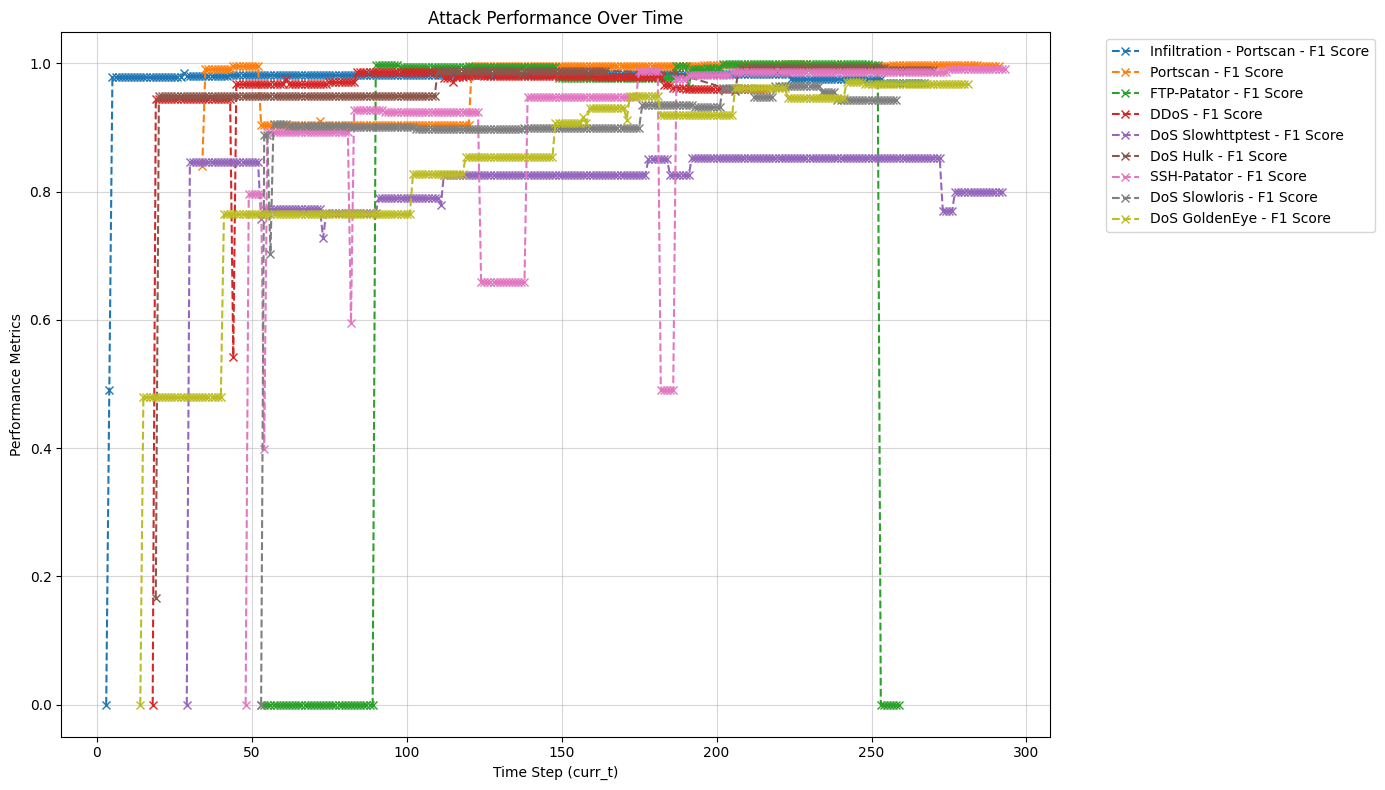

In [54]:
attack_avg_perfo = {}
for attack, data in attack_aggregates.items():
    if attack != "Infiltration - Portscan":
        # continue
        pass
    data = attack_aggregates[attack]
    # Step 1: Define the range for curr_t
    all_t_values = [t for sublist in data for t, _, _ in sublist]
    all_t_values.sort()
    min_t, max_t = min(all_t_values), max(all_t_values)

    # Step 2: Compute the average for each curr_t
    averaged_results = []

    # for curr_t in all_t_values:
    for curr_t in range(min_t,max_t):
        selected_values = []
        
        for sublist in data:
            if curr_t < sublist[0][0]:
                continue
            # Find the largest t <= curr_t in the current sublist
            valid_values = [item for item in sublist if item[0] >= curr_t]
            if valid_values:
                selected_values.append(valid_values[0])  # Use the last valid (largest t <= curr_t)
        
        if selected_values:
            # Average the selected accuracy and F1 scores
            avg_acc = np.mean([item[1] for item in selected_values])
            avg_f1 = np.mean([item[2] for item in selected_values])
            num_of_area = len(selected_values)
            averaged_results.append((curr_t, avg_acc, avg_f1, num_of_area))

    attack_avg_perfo[attack] = averaged_results

# Plot the averaged results for each attack
def plot_attack_performance(attack_avg_perfo):
    plt.figure(figsize=(14, 8))
    
    # Iterate through each attack
    for attack, performance in attack_avg_perfo.items():
        # plt.figure(figsize=(14, 8))
        # Extract data for plotting
        times = [item[0] for item in performance]
        # times = [i for i,item in enumerate(performance)]
        avg_accs = [item[1] for item in performance]
        avg_f1s = [item[2] for item in performance]
        num_areas = [item[3] for item in performance]
        
        # Plot accuracy
        # plt.plot(times, avg_accs, marker='o', label=f"{attack} - Accuracy")
        
        # Plot F1 score
        plt.plot(times, avg_f1s, marker='x', linestyle='--', label=f"{attack} - F1 Score")
        # plt.plot(times, avg_accs, marker='x', linestyle='--', label=f"{attack} - Accuracy")
        
    # Customize plot
    plt.xlabel("Time Step (curr_t)")
    plt.ylabel("Performance Metrics")
    plt.title("Attack Performance Over Time")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_attack_performance(attack_avg_perfo)


In [ ]:
performance

NameError: name 'performance' is not defined

### Epochs Comparison

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []

for epochs in np.arange(1, 10, 2):
    # Initialize and train the model
    clf = PReNet(device='cuda', verbose=1, epochs=epochs)
    clf.fit(X_gm_train.to_numpy(), y=y_gm_train)
    
    # Predict on the training data
    y_pred = clf.predict(X_gm_test.to_numpy())
    
    # Calculate metrics
    acc = accuracy_score(y_gm_test, y_pred)
    f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
    
    # Store the results
    acc_list.append((epochs, acc))
    f1_list.append((epochs, f1))
    
    print(f"Epochs: {epochs}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Start Training...
ensemble size: 1


KeyboardInterrupt: 

### Entire Data Accuracy

In [52]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []
X_gm_train, X_gm_test, y_gm_train, y_gm_test = preprocess_data(cicids_df)
# # Initialize and train the model
clf = PReNet(device='cuda', verbose=1, epochs=1, batch_size=64)
clf.fit(X_gm_train.to_numpy(), y=y_gm_train.values)



Start Training...
ensemble size: 1


KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(X_gm_test.to_numpy())

# Calculate metrics
acc = accuracy_score(y_gm_test, y_pred)
f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
print(acc, f1)


0.9857167712510247 0.923649259942822


### Individual Attack Accuracy

In [ ]:
clf = global_model.clf

In [ ]:
atk_info_list = define_atk(atk_list, edge_area_list, cicids_df, benign_df)
atk_acc = {}
atk_f1 = {}
atk_scores = {}
for attack in atk_info_list.values():
    print(f"__{attack.name}__")
    _, X_test, _, y_test = preprocess_data(attack.data.copy())
    y_pred = clf.predict(X_test.to_numpy())

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type    
    atk_acc[attack.name] = acc
    atk_f1[attack.name]=f1
    print(acc, f1)
    
    anomaly_scores = clf.decision_function(X_gm_test.to_numpy())
    atk_scores[attack.name] = anomaly_scores
    
    
    

__Portscan__
0.9528439759592324 0.7937964649697209
__DoS Hulk__
0.9821739403510031 0.9107028484746335
__DDoS__
0.9823961850290839 0.9117089379916271
__Infiltration - Portscan__
0.9344951982636446 0.6923882437809787
__DoS GoldenEye__
0.9887666527410296 0.9406280667320903
__FTP-Patator__
0.8738023542294004 0.16636528028933092
__DoS Slowloris__
0.9545066008167917 0.7909209951986033
__SSH-Patator__
0.8323497531012887 0.004291845493562232
__DoS Slowhttptest__
0.9651560926485397 0.8322017458777885


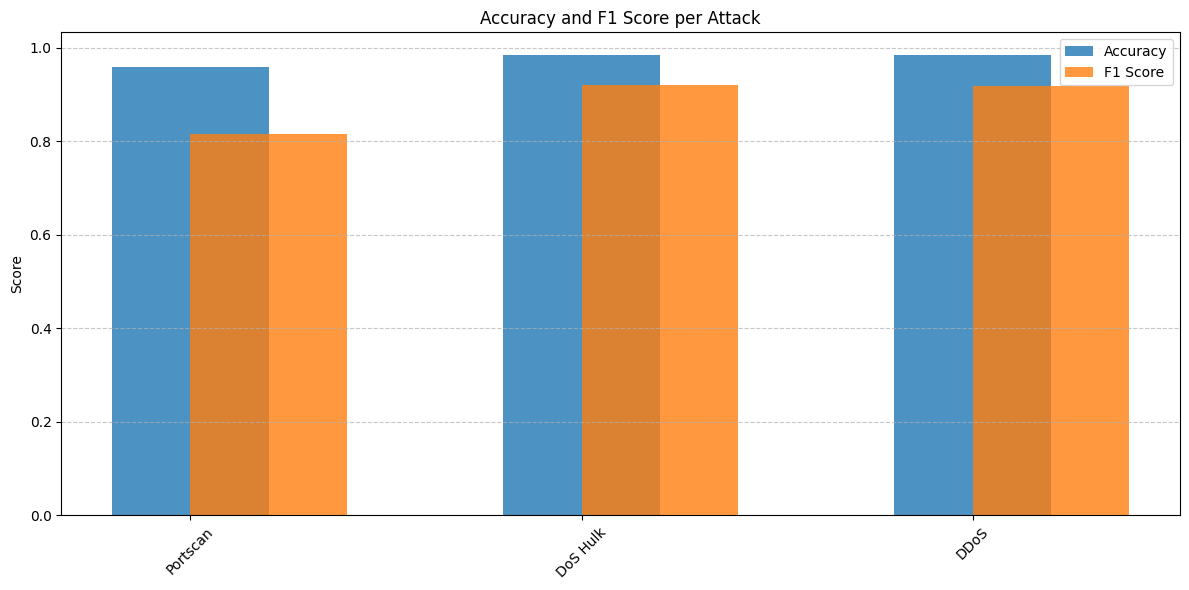

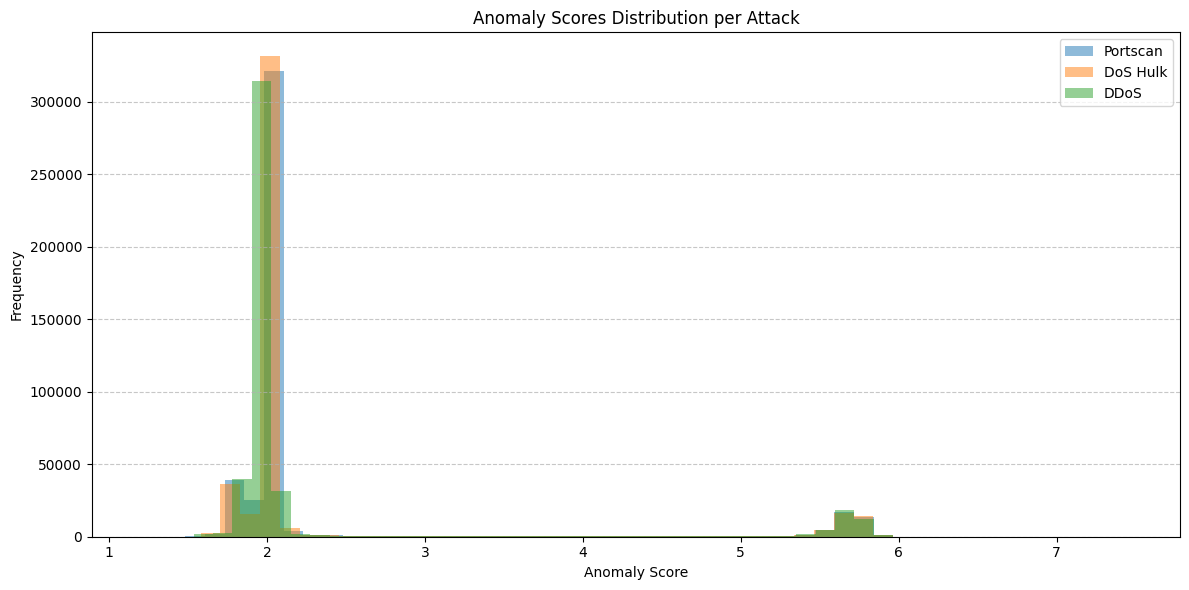

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy and F1 Score for each attack
def plot_metrics(atk_acc, atk_f1):
    attack_names = list(atk_acc.keys())
    accuracies = list(atk_acc.values())
    f1_scores = list(atk_f1.values())

    x = range(len(attack_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x, accuracies, width=0.4, label="Accuracy", align='center', alpha=0.8)
    plt.bar(x, f1_scores, width=0.4, label="F1 Score", align='edge', alpha=0.8)

    plt.xticks(x, attack_names, rotation=45)
    plt.ylabel("Score")
    plt.title("Accuracy and F1 Score per Attack")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot anomaly scores for each attack
def plot_anomaly_scores(atk_scores):
    plt.figure(figsize=(12, 6))

    for attack, scores in atk_scores.items():
        plt.hist(scores, bins=50, alpha=0.5, label=f"{attack}")

    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Anomaly Scores Distribution per Attack")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the functions
plot_metrics(atk_acc, atk_f1)
plot_anomaly_scores(atk_scores)


<Figure size 1000x600 with 0 Axes>

(array([1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 4.000e+00, 2.400e+01,
        1.900e+01, 4.900e+01, 1.830e+02, 1.010e+02, 6.630e+02, 2.290e+02,
        1.590e+03, 1.729e+03, 2.041e+03, 4.953e+03, 1.292e+03, 7.192e+03,
        2.695e+03, 5.684e+03, 4.922e+03, 1.984e+03, 3.829e+03, 8.820e+02,
        1.753e+03, 7.460e+02, 5.080e+02, 4.460e+02, 3.260e+02, 2.460e+02,
        2.260e+02, 1.930e+02, 1.160e+02, 1.110e+02, 7.100e+01, 4.200e+01,
        2.300e+01, 1.100e+01, 9.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 9.000e+00, 1.100e+0

(array([  1.,   2.,   0.,  12.,   3.,  20.,  26.,  29.,  50.,  19.,  85.,
         22.,  83.,  34.,  68.,  47.,  35.,  49.,  36.,  26.,  25.,  27.,
         31.,  30.,  22.,  21.,  16.,  21.,   6.,   2.,   2.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   6.,  13.,  17.,  37.,  70.,
        102., 119., 186., 212., 294., 346., 388., 374., 377., 302., 258.,
        208., 131.,  98.,  57.,  23.,  11.,   8.,   5.,   1.,   0.,   0.,
          2.]),
 array([1.12100303, 1.17780782, 1.23461261, 1.29141739, 1.34822218,
        1.40502697, 1.46183175, 1.51863654, 1.57544133, 1.63224611,
        1.6890509 , 1.74585569, 1.80266047, 1.85946526, 1.91627005,
        1.97307484, 2.02987962, 2.08668441, 2.1434892 , 2.20029398,
        2.25709877, 2.31390356, 2.37070834, 2.

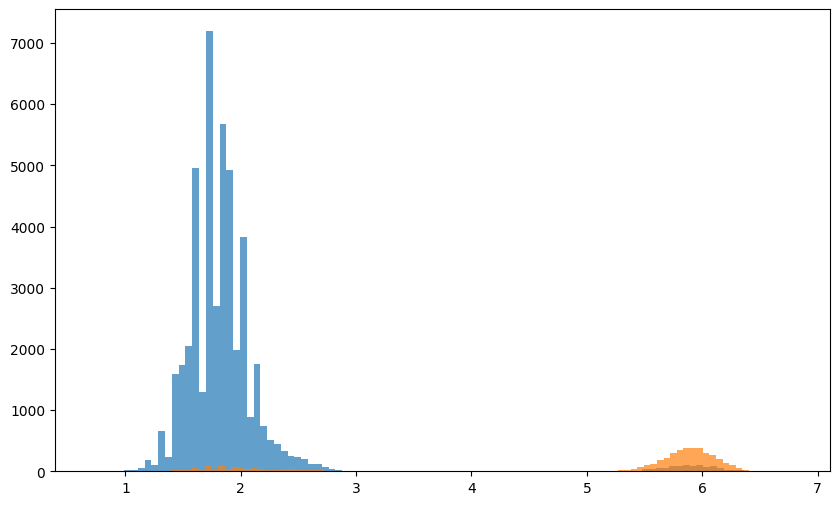

In [ ]:
scores_inliers = anomaly_scores[y_gm_test == 0]  # Assuming '0' is the label for inliers
scores_outliers = anomaly_scores[y_gm_test == 1]  # Assuming '1' is the label for outliers
# Create the plots
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot for inliers
plt.hist(scores_inliers, bins=100, alpha=0.7, label='Inliers')

# Plot for outliers
plt.hist(scores_outliers, bins=100, alpha=0.7, label='Outliers')

Functions

In [ ]:

def plot_graph_scenario(metrics_dict, supervision_rate_list):
    fig, axes = plt.subplots(2,1,figsize=(14, 8))  # Create a figure and a set of subplots.
    ax_n = 0
    for metric_type in metrics_dict:
        curr_ax = axes[ax_n]
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_supervision_rates = len(supervision_rate_list)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_supervision_rates))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(supervision_rate_list):
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(supervision_rate_list):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Supervision Rate: {sr}')

        curr_ax.set_title('ROC AUC Comparison by IP and Supervision Rate')
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_supervision_rates - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):


    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


ModuleNotFoundError: No module named 'modAL'

In [ ]:
# Read the csv and clean it
def eval_model_unsupervised(improved_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    X_train, X_test, y_train, y_test, scaler = process_dataset(improved_df, anomaly_rate)

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)

        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
            
        dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                        'Dst Port', 'Timestamp', 'Dvc Label']
        X_train.drop(dropping_cols, axis = 1, inplace = True)     
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
        
        # Train the model
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=X_train_scaled.to_numpy(), y=y)        
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate

            roc_auc = perform_inference(X_test, y_test, curr_ip, dropping_cols, scaler, clf)
            # Store metrics
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 

    return metrics_dict


# Fixing Accuracy

In [ ]:
from sklearn import metrics
def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)
  
# Read the csv and clean it
  
  
df = read_csv()
df = pd.concat([df[df['Label'] == 'BENIGN'], df[df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
ratio = df.loc[df["Label"] == "BENIGN"].shape[0]/ df.loc[df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 1.0
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()


    X_train, X_test, y_train, y_test = preprocess_data(improved_df)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    

supervision_rate_list = [1.0, 0.5, 0.25, 0.1, 0.05, 0.0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 0.135584, time: 276.3s
Start Inference on the training data...
Accuracy: 0.9964
Precision: 0.9867
Recall: 0.9981
F1 Score: 0.9924
[[1354556    5696]
 [    803  423921]]
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 0.5
Start Training...
ensemble size: 1


KeyboardInterrupt: 